## Test Notebook

In [1]:
import sys
from rdkit import Chem
from rdkit.Chem import AllChem
import rdkit.Chem.MolStandardize
import rdkit.Chem.MolStandardize.rdMolStandardize
import pandas as pd
import numpy as np
from pyteomics import mgf
import matplotlib.pyplot as plt
from data_utils import *
import operator
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras import optimizers
from keras.utils import plot_model
import tensorflow as tf
from IPython.display import SVG
from keras.utils import model_to_dot

RDKit WARNING: [20:24:04] Enabling RDKit 2019.09.3 jupyter extensions
Using TensorFlow backend.


In [2]:
## Check GPU available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.experimental.list_physical_devices('GPU'))
tf.debugging.set_log_device_placement(False)

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Read data and split

#### Note: 
- Data not included with source code at request of supervisor.
- Can be downloaded at https://www.dropbox.com/s/n0xhosdnjl8963f/MS_data_allGNPS_uniqueInchikey14_191101.mgf?dl=0 (~200mb)
- must be placed in /data/raw/ folder for use by fetch_data function

In [3]:
unique_mols = fetch_data("unique")

temp_x, temp_y = [], []

for _, mol in unique_mols.iterrows():
    temp_x.append(mol['fingerprint'])
    temp_y.append(mol['normed_binned'])
    
np.random.seed(2)
msk = np.random.rand(len(unique_mols)) < 0.8

train_mols = unique_mols.iloc[msk].reset_index()
test_mols = unique_mols.iloc[~msk].reset_index()
    
x_train = np.array(temp_x, dtype=np.float64)[msk]
y_train = np.array(temp_y, dtype=np.float64)[msk]

x_test = np.array(temp_x, dtype=np.float64)[~msk]
y_test = np.array(temp_y, dtype=np.float64)[~msk]

num molecules in raw file:  8249


RDKit ERROR: [20:24:20] Can't kekulize mol.  Unkekulized atoms: 10 11 12 14 16
RDKit ERROR: 


unable to generate fp for entry 1257


RDKit ERROR: [20:24:20] SMILES Parse Error: unclosed ring for input: 'OC1=CC(C(OC)=O)=C(OC2=CC(C)=CC(O)=C2C(O)=O)C(OC)=C2'
RDKit ERROR: [20:24:20] SMILES Parse Error: unclosed ring for input: 'O=C1C2=C(C=C(C)C=C2O)OC3=CC(O)=CC(C(OC)=O)=C32'
RDKit ERROR: [20:24:20] SMILES Parse Error: unclosed ring for input: 'O=C([C@H](CC)C)O[C@H]1CCC=C2C1[C@@H](CC[C@@H](O)C[C@@H](O)CC(OC)=O)[C@@H](C)C=C3'
RDKit ERROR: [20:24:20] SMILES Parse Error: unclosed ring for input: 'O=C(N[C@@H](CCCCCC(CC)=O)C(N[C@@H](CC1=CN(OC)C2=C1C=CC=C2)C3=O)=O)[C@@H]4N(C([C@H]([C@H](CC)C)N3)=O)CCCC5'


unable to generate fp for entry 1318
unable to generate fp for entry 1320
unable to generate fp for entry 1340
unable to generate fp for entry 1346


RDKit ERROR: [20:24:20] SMILES Parse Error: unclosed ring for input: 'O=C(N(C(C=CC=C1)=C1C(N(C)[C@@]2([H])CC3=CC=CC=C3)=O)C2=N4)C5=C4C=CC=C6'
RDKit ERROR: [20:24:20] SMILES Parse Error: unclosed ring for input: 'OC1=CC=C(CC(C(NC(C(CC)C)C(OC(C(CCCCCCCCCC)C)CC(NC(C(NC(C(NC(C(NC2CCC(N)=O)=O)C)=O)C)=O)C(O)C)=O)=O)=O)NC2=O)C=C2'


unable to generate fp for entry 1351
unable to generate fp for entry 1356


RDKit ERROR: [20:24:24] non-ring atom 88 marked aromatic
RDKit ERROR: [20:24:24] non-ring atom 90 marked aromatic


unable to generate fp for entry 1855
unable to generate fp for entry 1856


RDKit WARNING: [20:24:58] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [20:25:14] SMILES Parse Error: syntax error while parsing: N/A
RDKit ERROR: [20:25:14] SMILES Parse Error: Failed parsing SMILES 'N/A' for input: 'N/A'


unable to generate fp for entry 7214
num parsed molecules:  8239
finished


## Data analysis

In [4]:
peak_counts = np.zeros(np.shape(y_train)[1])

for mol in y_train:
    for i, val in enumerate(mol):
        if val > 0:
            peak_counts[i] += 1

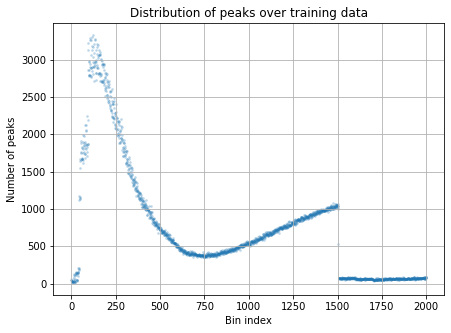

In [5]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)
plt.scatter(range(np.shape(y_train)[1]), peak_counts, alpha=0.2, s=3)
plt.grid()
plt.title("Distribution of peaks over training data")
plt.xlabel("Bin index")
plt.ylabel("Number of peaks")
#plt.savefig("../dissertation/graphs/peak_distribution.pdf")
plt.show()

In [6]:
standard_deviations = np.zeros(np.shape(y_train)[1])

for i in range(np.shape(y_train)[1]):
    standard_deviations[i] = np.std(y_train[:, i])


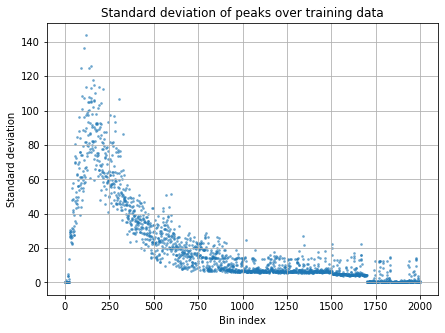

In [7]:

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)
plt.scatter(range(np.shape(y_train)[1]), standard_deviations, alpha=0.5, s=3)
plt.grid()
plt.title("Standard deviation of peaks over training data")
plt.xlabel("Bin index")
plt.ylabel("Standard deviation")
#plt.savefig("../dissertation/graphs/std_deviation.pdf")
plt.show()

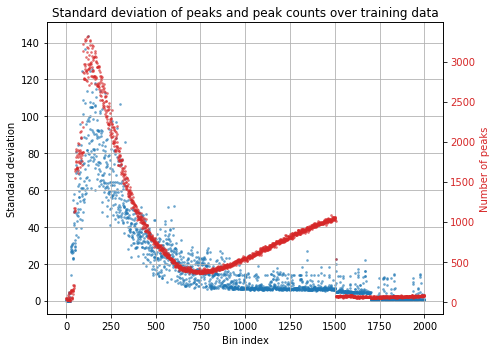

In [8]:
fig = plt.figure(figsize=(7,5))
ax1 = fig.add_subplot(1,1,1)
ax1.scatter(range(np.shape(y_train)[1]), standard_deviations, alpha=0.5, s=3)
plt.grid()
plt.title("Standard deviation of peaks and peak counts over training data")
plt.xlabel("Bin index")
plt.ylabel("Standard deviation")

#plt.show()

color = 'tab:red'
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Number of peaks', color=color)  # we already handled the x-label with ax1
ax2.scatter(range(np.shape(y_train)[1]), peak_counts, alpha=0.5, s=3, color=color)
ax2.tick_params(axis='y', labelcolor=color)
#plt.savefig("../dissertation/graphs/std_deviation_distribution_combined.pdf")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [9]:
# get candidate bin indexes
high_std = [i for i, j in enumerate(standard_deviations) if j > 100 and j < 120 ]
medium_std = [i for i, j in enumerate(standard_deviations) if j > 40 and j < 60 ]
low_std_low_n = range(700, 800)
low_std_medium_n = range(1400, 1500)

np.random.seed(0)
candidates = []
candidates.append(high_std[np.random.randint(0, len(high_std))])
candidates.append(medium_std[np.random.randint(0, len(medium_std))])
candidates.append(low_std_low_n[np.random.randint(0, len(low_std_low_n))])
candidates.append(low_std_medium_n[np.random.randint(0, len(low_std_medium_n))])
print(candidates)

[159, 258, 764, 1467]


## Comparing units (3 hidden layers)


Progress  :  1 / 24
Candidate :  159
Units    :  16
1639/1639 [==============================] - 0s 45us/step
loss 14925.875736169077
mae 45.66484069824219


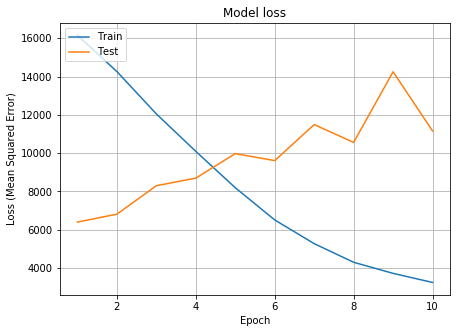


Progress  :  2 / 24
Candidate :  159
Units    :  64
1639/1639 [==============================] - 0s 30us/step
loss 15674.59997341675
mae 44.5587158203125


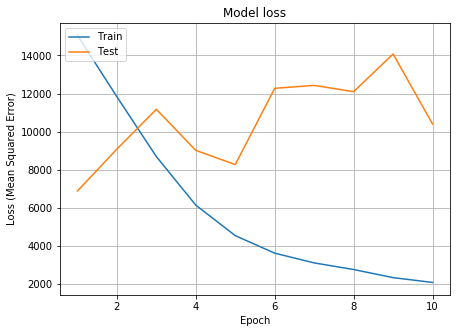


Progress  :  3 / 24
Candidate :  159
Units    :  256
1639/1639 [==============================] - 0s 31us/step
loss 14962.271573178574
mae 41.45286178588867


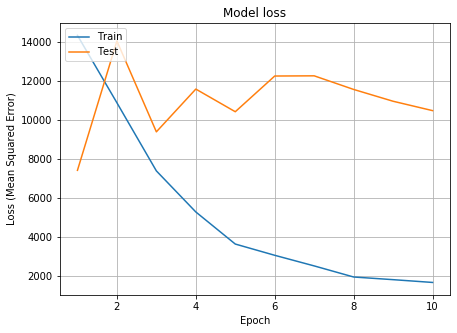


Progress  :  4 / 24
Candidate :  159
Units    :  1024
1639/1639 [==============================] - 0s 39us/step
loss 15665.909409195567
mae 43.091434478759766


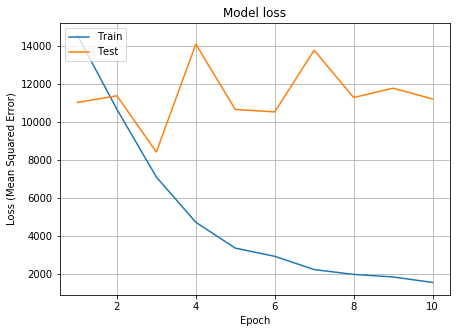


Progress  :  5 / 24
Candidate :  159
Units    :  2048
1639/1639 [==============================] - 0s 49us/step
loss 14895.967394418001
mae 41.149200439453125


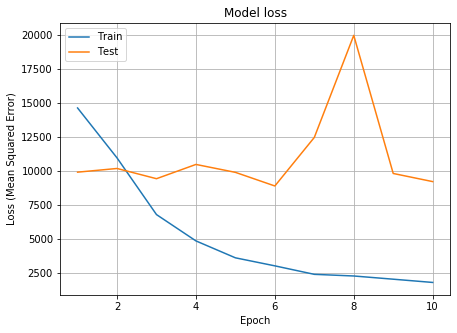


Progress  :  6 / 24
Candidate :  159
Units    :  4096
1639/1639 [==============================] - 0s 68us/step
loss 15910.448263535181
mae 42.70170593261719


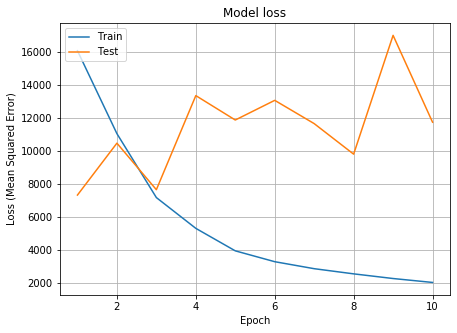


Progress  :  7 / 24
Candidate :  258
Units    :  16
1639/1639 [==============================] - 0s 30us/step
loss 2427.4220767763054
mae 10.975014686584473


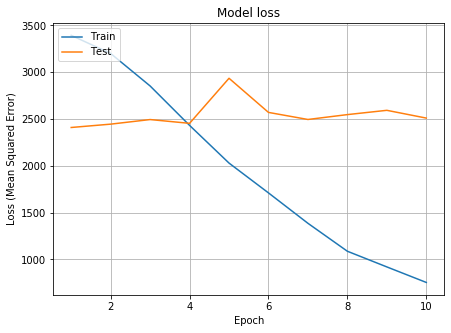


Progress  :  8 / 24
Candidate :  258
Units    :  64
1639/1639 [==============================] - 0s 44us/step
loss 2653.912629699474
mae 12.472193717956543


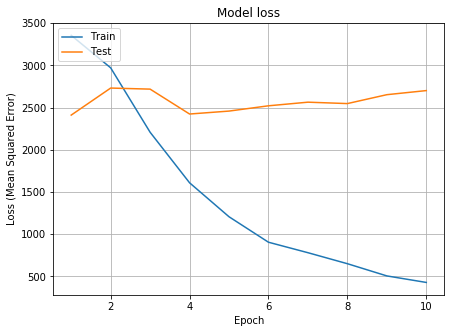


Progress  :  9 / 24
Candidate :  258
Units    :  256
1639/1639 [==============================] - 0s 34us/step
loss 2699.1225867297608
mae 11.696708679199219


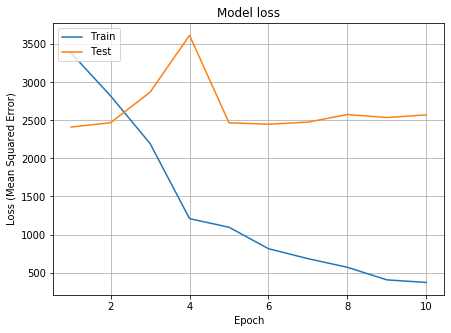


Progress  :  10 / 24
Candidate :  258
Units    :  1024
1639/1639 [==============================] - 0s 36us/step
loss 2604.3121770215225
mae 11.580069541931152


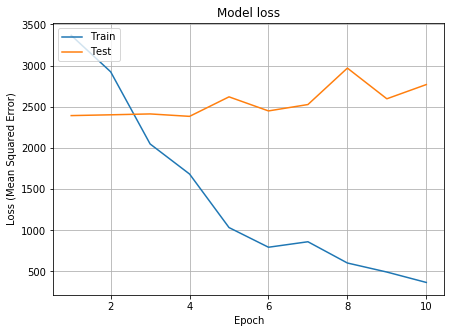


Progress  :  11 / 24
Candidate :  258
Units    :  2048
1639/1639 [==============================] - 0s 45us/step
loss 2580.9446567945033
mae 9.713430404663086


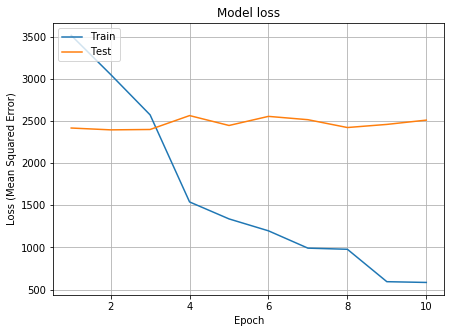


Progress  :  12 / 24
Candidate :  258
Units    :  4096
1639/1639 [==============================] - 0s 67us/step
loss 2395.2636388862475
mae 9.774372100830078


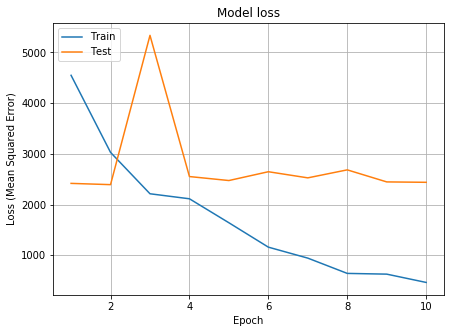


Progress  :  13 / 24
Candidate :  764
Units    :  16
1639/1639 [==============================] - 0s 27us/step
loss 969.1093468140945
mae 2.709928512573242


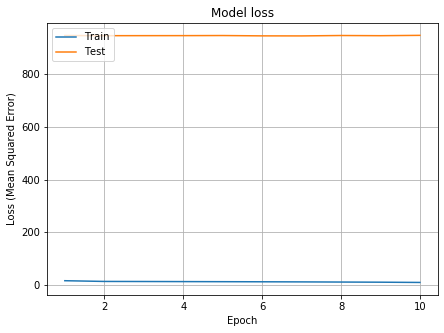


Progress  :  14 / 24
Candidate :  764
Units    :  64
1639/1639 [==============================] - 0s 27us/step
loss 968.3364366647527
mae 2.5151853561401367


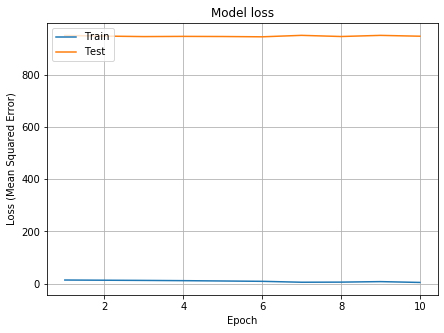


Progress  :  15 / 24
Candidate :  764
Units    :  256
1639/1639 [==============================] - 0s 29us/step
loss 963.3762389710213
mae 3.636784315109253


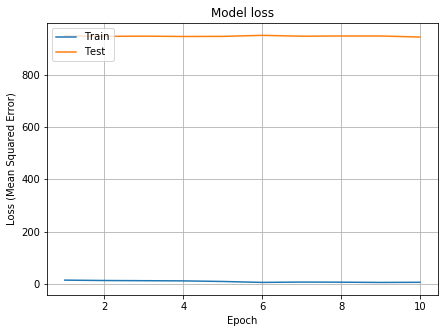


Progress  :  16 / 24
Candidate :  764
Units    :  1024
1639/1639 [==============================] - 0s 38us/step
loss 967.7166460458828
mae 2.469998598098755


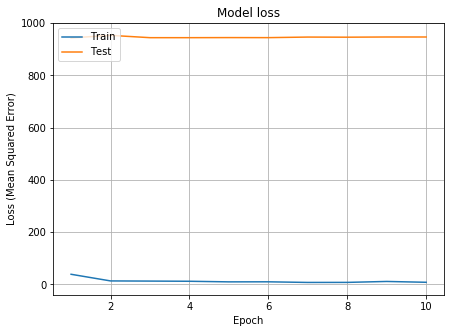


Progress  :  17 / 24
Candidate :  764
Units    :  2048
1639/1639 [==============================] - 0s 46us/step
loss 968.1674496620948
mae 2.406663417816162


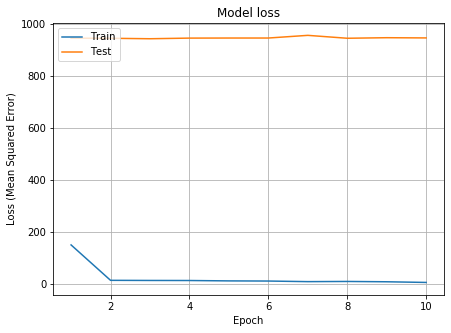


Progress  :  18 / 24
Candidate :  764
Units    :  4096
1639/1639 [==============================] - 0s 67us/step
loss 969.6197540252818
mae 2.6247196197509766


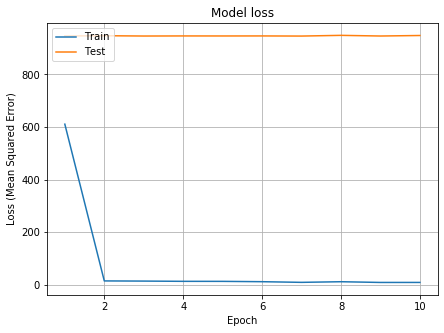


Progress  :  19 / 24
Candidate :  1467
Units    :  16
1639/1639 [==============================] - 0s 32us/step
loss 1607.9024274980534
mae 6.245119094848633


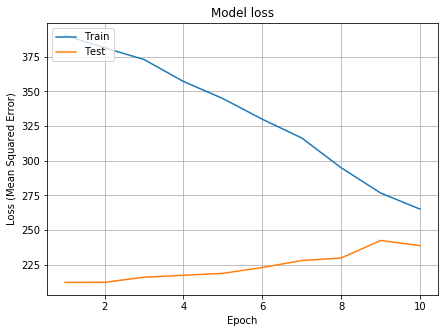


Progress  :  20 / 24
Candidate :  1467
Units    :  64
1639/1639 [==============================] - 0s 35us/step
loss 1571.4880295265295
mae 6.163384914398193


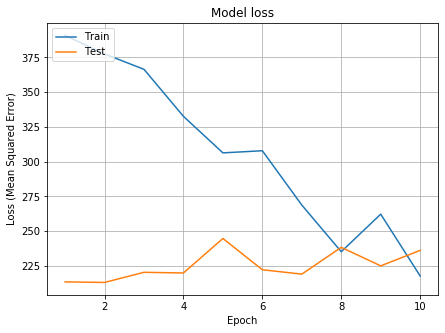


Progress  :  21 / 24
Candidate :  1467
Units    :  256
1639/1639 [==============================] - 0s 30us/step
loss 1595.9369094890744
mae 5.810273170471191


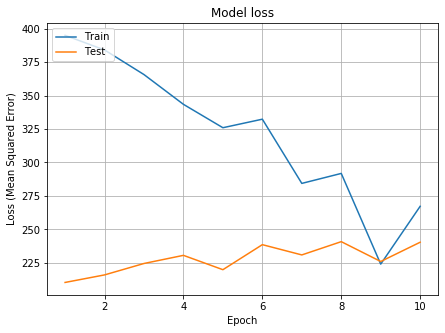


Progress  :  22 / 24
Candidate :  1467
Units    :  1024
1639/1639 [==============================] - 0s 37us/step
loss 1591.85775306299
mae 5.565829277038574


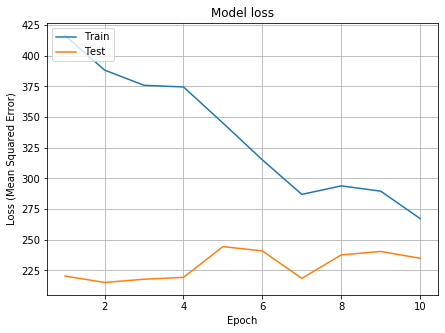


Progress  :  23 / 24
Candidate :  1467
Units    :  2048
1639/1639 [==============================] - 0s 45us/step
loss 1586.4218893418722
mae 5.203780174255371


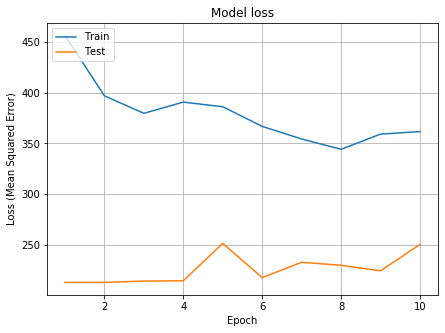


Progress  :  24 / 24
Candidate :  1467
Units    :  4096
1639/1639 [==============================] - 0s 66us/step
loss 1563.9806783581885
mae 7.7994208335876465


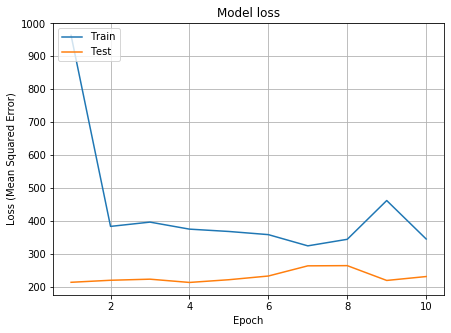

In [10]:
candidate_results = {
    159: [],
    258: [],
    764: [],
    1467: [],
}

params = {
    'units': [16, 64, 256, 1024, 2048, 4096],
    }

total = len(candidates) * len(params['units'])
trained = 0

for candidate in candidates:
    for x in params['units']:
        trained += 1
        print("\nProgress  : ", trained, "/", total)
        print("Candidate : ", candidate)
        print("Units    : ", x)
                
        model = Sequential()
        model.add(Dense(units=x, activation='relu', input_shape=(4096,),  bias_initializer='ones'))
        model.add(Dense(units=x, activation='relu',  bias_initializer='ones'))
        model.add(Dense(units=x, activation='relu',  bias_initializer='ones'))
        model.add(Dense(units=1))
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

        y_train_data = normalize(y_train[:, candidate])
        y_test_data = normalize(y_test[:, candidate])
        history = model.fit(x_train, y_train_data, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
        results = model.evaluate(x_test, y_test_data, batch_size=32, verbose=1)
        labels = model.metrics_names
        
        # results = [loss, mae]
        for i in range(len(results)):
            print(labels[i], results[i])
            
        candidate_results[candidate].append(results[0])

        #Plot training & validation loss values
        fig = plt.figure(figsize=(7,5))
        ax = fig.add_subplot(1,1,1)
        ax.plot(range(1, len(history.history['loss'])+1), history.history['loss'])
        ax.plot(range(1, len(history.history['loss'])+1), history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss (Mean Squared Error)')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.grid()
        #plt.savefig("../dissertation/images/adam512.pdf")
        plt.show()
        
        predictions = model.predict(x_test)
        if np.all(predictions == 0):
            print("------------------ALL ZERO PREDICTIONS---------------------")

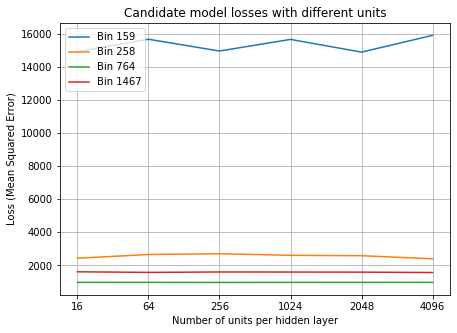

In [11]:
#Plot comparison bar chart
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)
X = np.arange(0, 8, 2)

legend = []
for c in candidates:
    legend.append('Bin ' + str(c))
    ax.plot(candidate_results[c])
    
plt.title('Candidate model losses with different units')
plt.ylabel('Loss (Mean Squared Error)')
plt.xticks(range(len(params['units'])), params['units'])
plt.legend(legend, loc='upper left')
plt.xlabel("Number of units per hidden layer")
plt.grid()
#plt.ylim(0,4000)
#plt.savefig("../dissertation/graphs/candidate-units.pdf")
plt.show()

## Comparing number of hidden layers (256 units)


Progress :  1 / 28
Candidate    :  159
Layers   :  1
1639/1639 [==============================] - 0s 30us/step
loss 17261.76282051091
mae 70.43556213378906


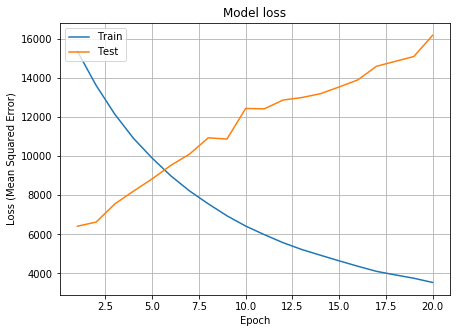


Progress :  2 / 28
Candidate    :  159
Layers   :  2
1639/1639 [==============================] - 0s 30us/step
loss 18788.924545874605
mae 51.33464431762695


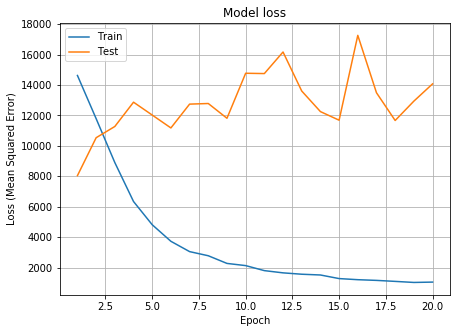


Progress :  3 / 28
Candidate    :  159
Layers   :  3
1639/1639 [==============================] - 0s 44us/step
loss 19892.61086128324
mae 48.24249267578125


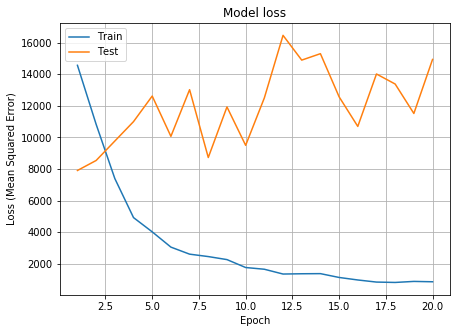


Progress :  4 / 28
Candidate    :  159
Layers   :  4
1639/1639 [==============================] - 0s 31us/step
loss 16930.410800656144
mae 45.4075927734375


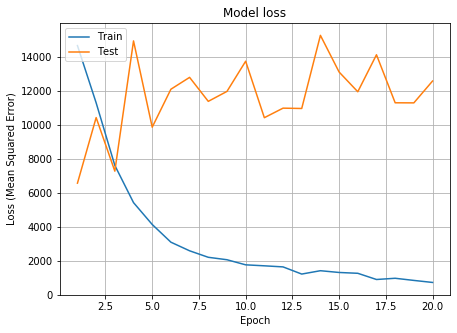


Progress :  5 / 28
Candidate    :  159
Layers   :  5
1639/1639 [==============================] - 0s 30us/step
loss 17971.08072961984
mae 44.78474044799805


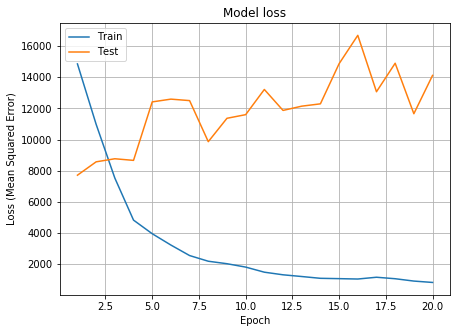


Progress :  6 / 28
Candidate    :  159
Layers   :  6
1639/1639 [==============================] - 0s 39us/step
loss 15160.425389721016
mae 42.95835494995117


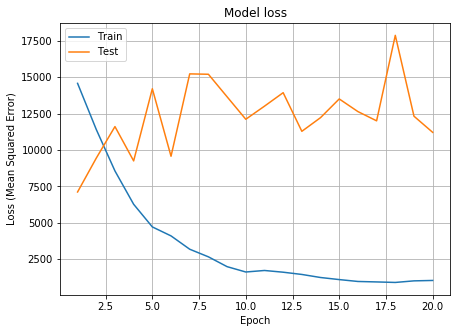


Progress :  7 / 28
Candidate    :  159
Layers   :  7
1639/1639 [==============================] - 0s 35us/step
loss 15913.1355168015
mae 43.66082000732422


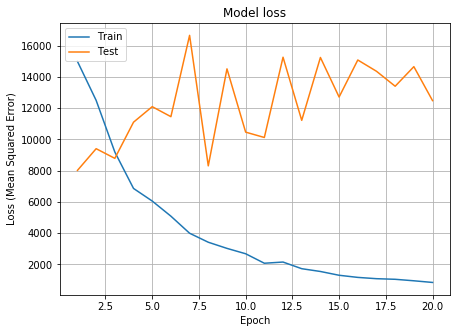


Progress :  8 / 28
Candidate    :  258
Layers   :  1
1639/1639 [==============================] - 0s 33us/step
loss 3389.104884987273
mae 30.174972534179688


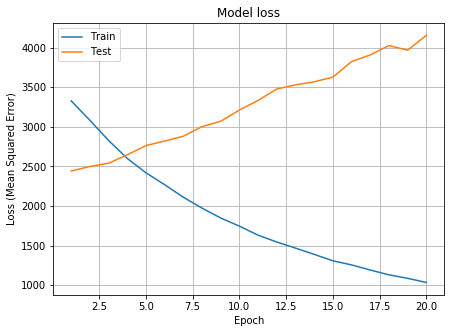


Progress :  9 / 28
Candidate    :  258
Layers   :  2
1639/1639 [==============================] - 0s 29us/step
loss 2670.7281067145896
mae 13.576244354248047


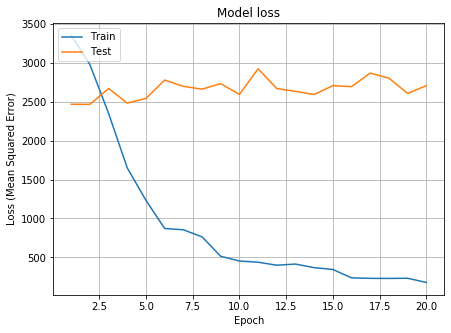


Progress :  10 / 28
Candidate    :  258
Layers   :  3
1639/1639 [==============================] - 0s 29us/step
loss 2568.183032823671
mae 10.71754264831543


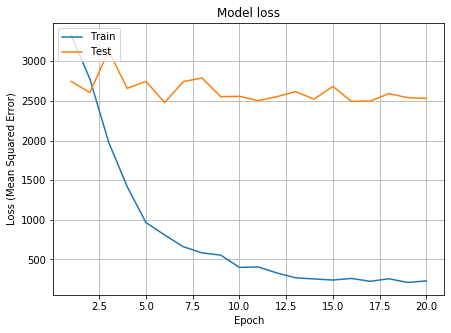


Progress :  11 / 28
Candidate    :  258
Layers   :  4
1639/1639 [==============================] - 0s 31us/step
loss 2759.175139635492
mae 11.229540824890137


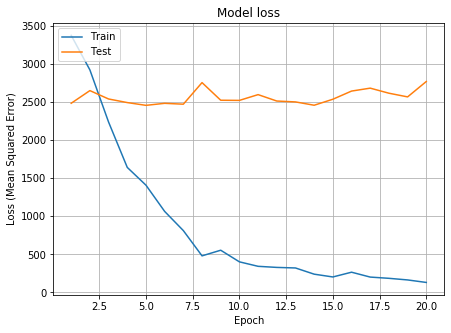


Progress :  12 / 28
Candidate    :  258
Layers   :  5
1639/1639 [==============================] - 0s 39us/step
loss 2989.718778798753
mae 10.360312461853027


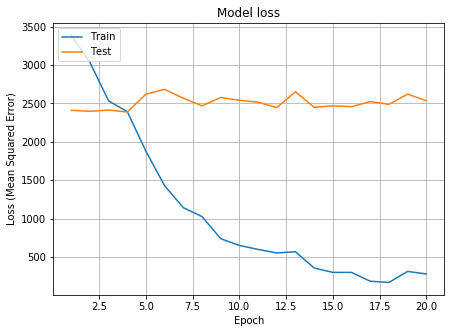


Progress :  13 / 28
Candidate    :  258
Layers   :  6
1639/1639 [==============================] - 0s 30us/step
loss 2859.784868643006
mae 10.371882438659668


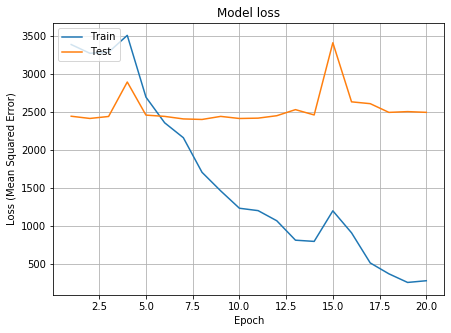


Progress :  14 / 28
Candidate    :  258
Layers   :  7
1639/1639 [==============================] - 0s 34us/step
loss 2969.3822992544774
mae 10.178267478942871


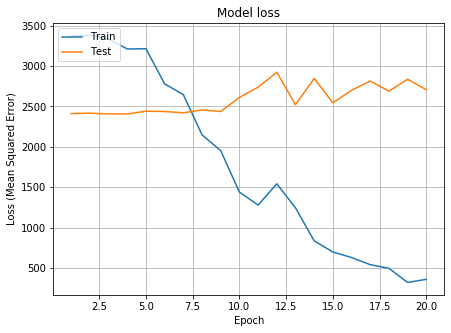


Progress :  15 / 28
Candidate    :  764
Layers   :  1
1639/1639 [==============================] - 0s 32us/step
loss 972.885328858418
mae 3.578794479370117


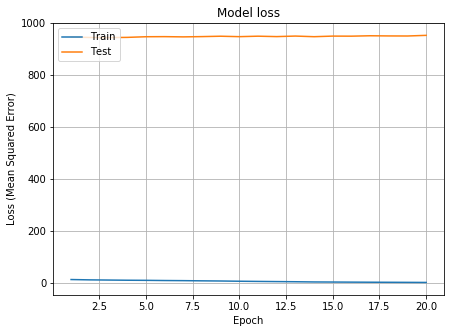


Progress :  16 / 28
Candidate    :  764
Layers   :  2
1639/1639 [==============================] - 0s 30us/step
loss 968.9013617636047
mae 2.5917489528656006


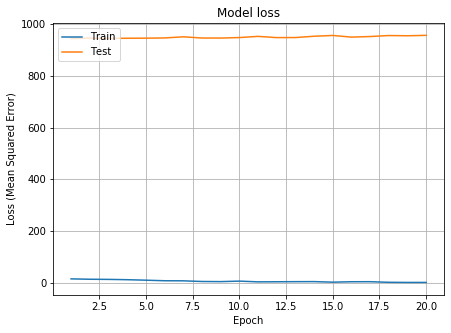


Progress :  17 / 28
Candidate    :  764
Layers   :  3
1639/1639 [==============================] - 0s 34us/step
loss 966.3195846365347
mae 2.384514093399048


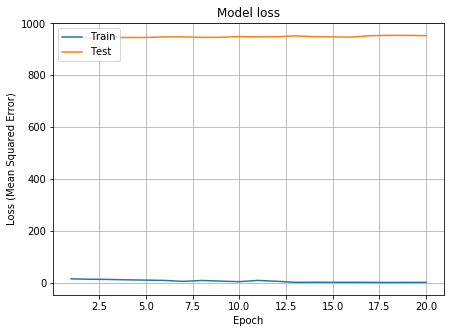


Progress :  18 / 28
Candidate    :  764
Layers   :  4
1639/1639 [==============================] - 0s 46us/step
loss 967.3878074199997
mae 2.321281671524048


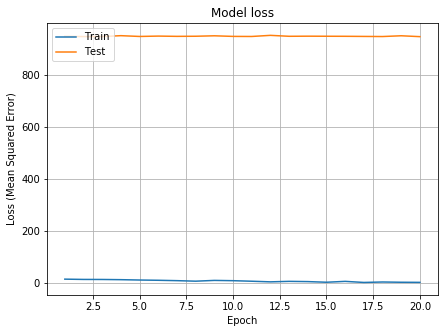


Progress :  19 / 28
Candidate    :  764
Layers   :  5
1639/1639 [==============================] - 0s 31us/step
loss 967.2652709401185
mae 2.3770267963409424


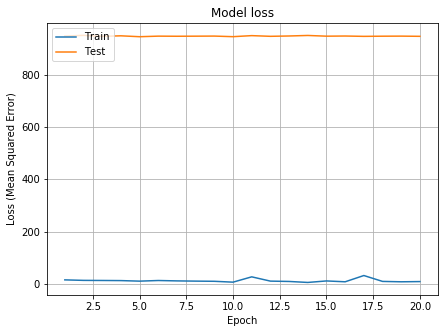


Progress :  20 / 28
Candidate    :  764
Layers   :  6
1639/1639 [==============================] - 0s 33us/step
loss 968.8488488552309
mae 2.3239190578460693


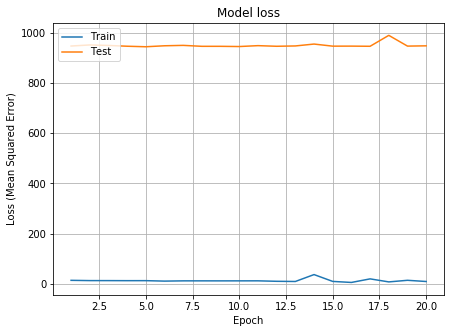


Progress :  21 / 28
Candidate    :  764
Layers   :  7
1639/1639 [==============================] - 0s 34us/step
loss 968.3545190230489
mae 2.2638092041015625


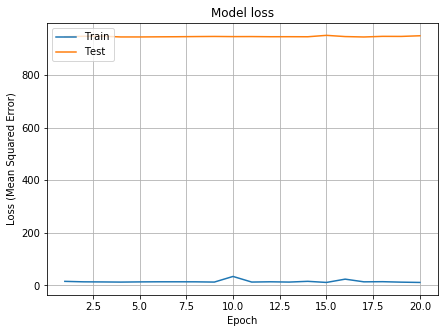


Progress :  22 / 28
Candidate    :  1467
Layers   :  1
1639/1639 [==============================] - 0s 39us/step
loss 1687.129158857321
mae 9.062771797180176


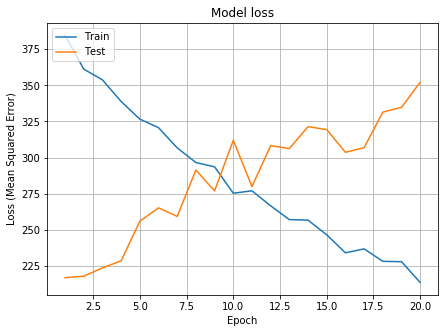


Progress :  23 / 28
Candidate    :  1467
Layers   :  2
1639/1639 [==============================] - 0s 32us/step
loss 1581.383450170346
mae 5.793821334838867


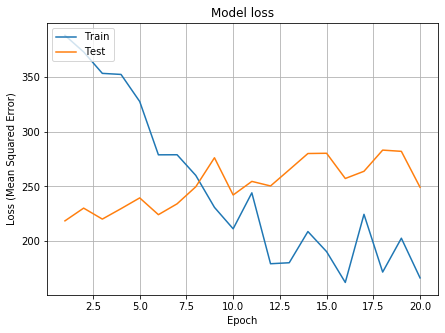


Progress :  24 / 28
Candidate    :  1467
Layers   :  3
1639/1639 [==============================] - 0s 35us/step
loss 1616.4746305641047
mae 5.5909271240234375


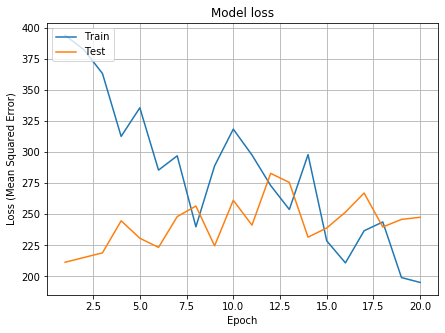


Progress :  25 / 28
Candidate    :  1467
Layers   :  4
1639/1639 [==============================] - 0s 31us/step
loss 1586.8792829653923
mae 5.297225475311279


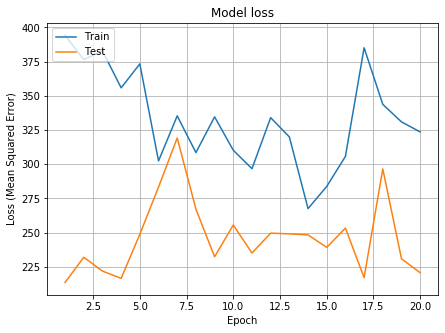


Progress :  26 / 28
Candidate    :  1467
Layers   :  5
1639/1639 [==============================] - 0s 33us/step
loss 1580.63411980441
mae 5.166834354400635


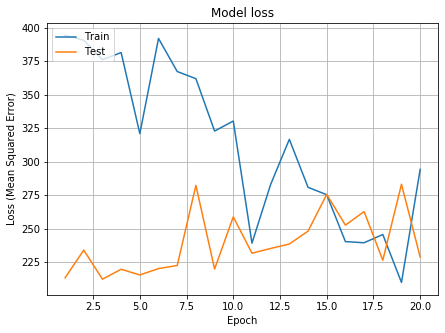


Progress :  27 / 28
Candidate    :  1467
Layers   :  6
1639/1639 [==============================] - 0s 51us/step
loss 1587.638150767992
mae 5.351238250732422


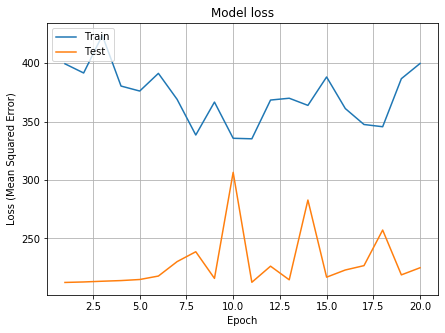


Progress :  28 / 28
Candidate    :  1467
Layers   :  7
1639/1639 [==============================] - 0s 31us/step
loss 1576.0807178902364
mae 5.864497184753418


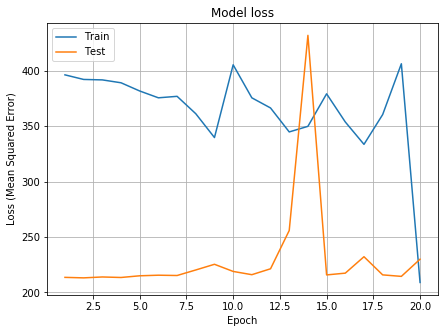

In [12]:
candidate_results2 = {
    159: [],
    258: [],
    764: [],
    1467: [],
}

params = {
    'layers': [1, 2, 3, 4, 5, 6, 7],
    }

total = len(params['layers']) * len(candidates)
trained = 0

for candidate in candidates:
    for num_layers in params['layers']:
        trained += 1
        print("\nProgress : ", trained, "/", total)
        print("Candidate    : ", candidate)
        print("Layers   : ", num_layers)

                
        model = Sequential()
        model.add(Dense(units=256, activation='relu', input_shape=(4096,), bias_initializer='ones'))
        for _ in range(num_layers -1):
            model.add(Dense(units=256, activation='relu', bias_initializer='ones'))
        model.add(Dense(units=1))
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

        y_train_data = normalize(y_train[:, candidate])
        y_test_data = normalize(y_test[:, candidate])
        history = model.fit(x_train, y_train_data, epochs=20, batch_size=32, validation_split=0.2, verbose=0)
        results = model.evaluate(x_test, y_test_data, batch_size=32, verbose=1)
        labels = model.metrics_names
        
        
        # results = [loss, mae]
        for i in range(len(results)):
            print(labels[i], results[i])
            
        candidate_results2[candidate].append(results[0])

        #Plot training & validation loss values
        fig = plt.figure(figsize=(7,5))
        ax = fig.add_subplot(1,1,1)
        ax.plot(range(1, len(history.history['loss'])+1), history.history['loss'])
        ax.plot(range(1, len(history.history['loss'])+1), history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss (Mean Squared Error)')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.grid()
        plt.show()
        
        predictions = model.predict(x_test)
        if np.all(predictions == 0):
            print("   !!!   ALL ZERO PREDICTIONS   !!!   ")

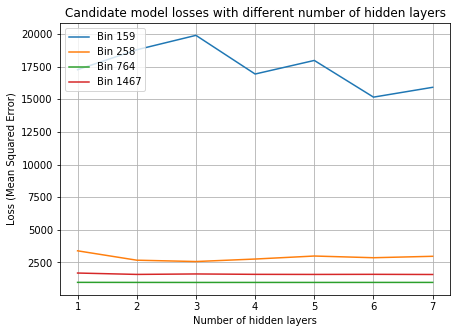

In [14]:
#Plot comparison bar chart
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)
X = np.arange(0, 8, 2)

legend = []
for c in candidates:
    legend.append('Bin ' + str(c))
    ax.plot(candidate_results2[c])
    
plt.title('Candidate model losses with different number of hidden layers')
plt.ylabel('Loss (Mean Squared Error)')
plt.xticks(range(len(params['layers'])), params['layers'])
plt.legend(legend, loc='upper left')
plt.xlabel("Number of hidden layers")
plt.grid()
#plt.ylim(0,4000)
plt.savefig("../dissertation/graphs/candidate-units.pdf")
plt.show()

## Comparing dropout rate (256 units, 6 hidden layers)


Progress   :  1 / 28
Candidate  :  159
Dropout    :  0
Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 31us/step
loss 15487.958583347096
mae 42.41470718383789


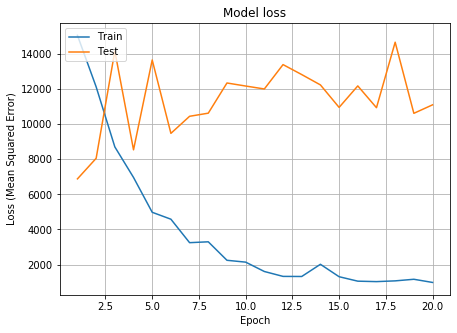


Progress   :  2 / 28
Candidate  :  159
Dropout    :  0.05
Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 38us/step
loss 20300.133647367675
mae 47.44057083129883


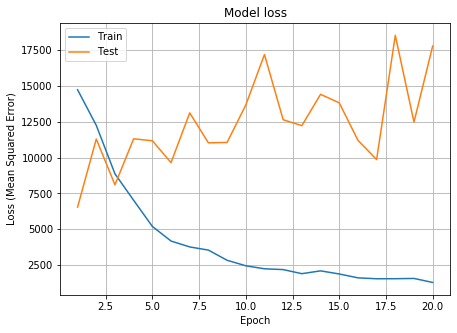


Progress   :  3 / 28
Candidate  :  159
Dropout    :  0.1
Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 37us/step
loss 14528.261646296354
mae 40.37020492553711


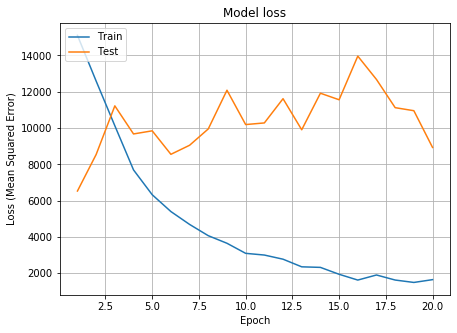


Progress   :  4 / 28
Candidate  :  159
Dropout    :  0.15
Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 38us/step
loss 22763.55956538848
mae 49.10700225830078


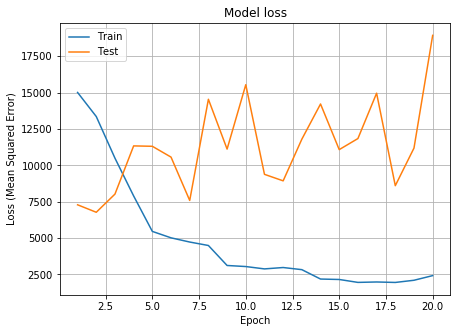


Progress   :  5 / 28
Candidate  :  159
Dropout    :  0.2
Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 35us/step
loss 16377.724885776466
mae 44.76478576660156


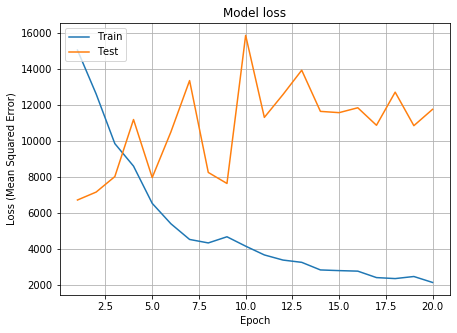


Progress   :  6 / 28
Candidate  :  159
Dropout    :  0.25
Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 37us/step
loss 14748.051664691062
mae 41.65178680419922


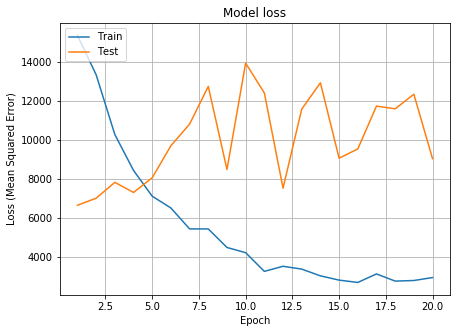


Progress   :  7 / 28
Candidate  :  159
Dropout    :  0.3
Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 37us/step
loss 16128.789714336104
mae 45.15862274169922


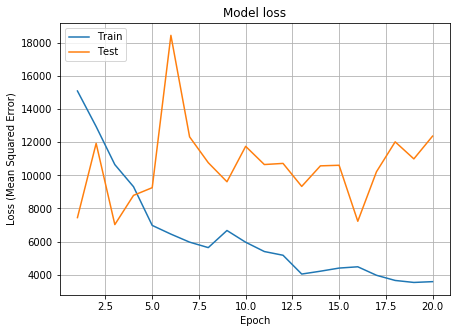


Progress   :  8 / 28
Candidate  :  258
Dropout    :  0
Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 34us/step
loss 2732.519077294043
mae 10.302437782287598


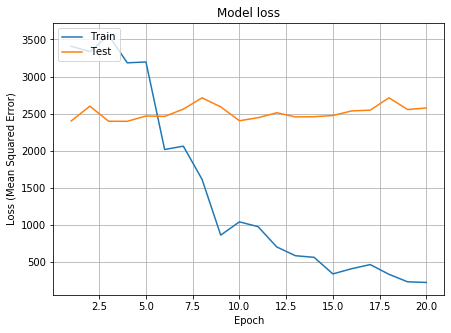


Progress   :  9 / 28
Candidate  :  258
Dropout    :  0.05
Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 37us/step
loss 2478.540156824695
mae 10.1395263671875


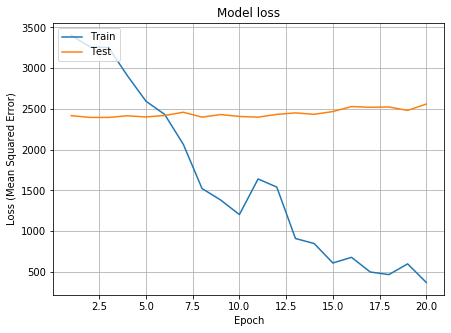


Progress   :  10 / 28
Candidate  :  258
Dropout    :  0.1
Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 35us/step
loss 3081.782970854391
mae 13.0374116897583


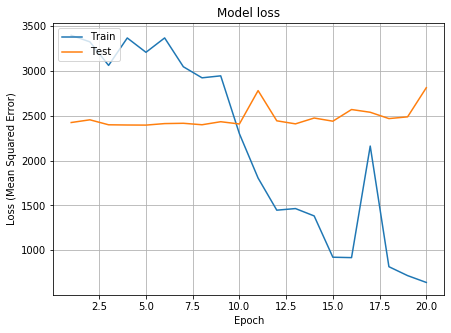


Progress   :  11 / 28
Candidate  :  258
Dropout    :  0.15
Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 36us/step
loss 2925.695730476717
mae 10.542195320129395


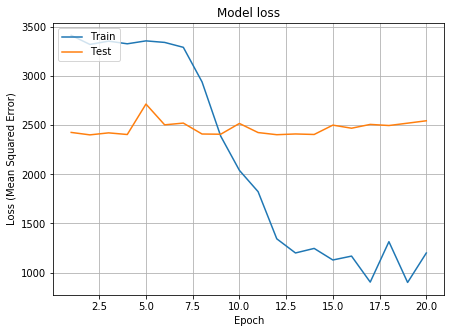


Progress   :  12 / 28
Candidate  :  258
Dropout    :  0.2
Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 34us/step
loss 2255.721908222545
mae 10.266454696655273


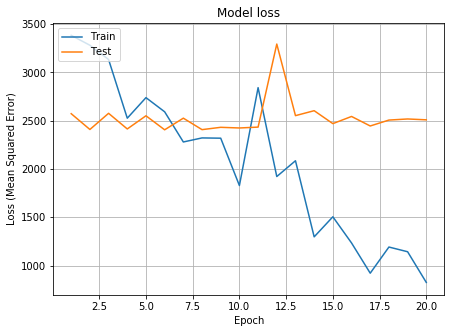


Progress   :  13 / 28
Candidate  :  258
Dropout    :  0.25
Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 36us/step
loss 2683.9975123239624
mae 11.195034980773926


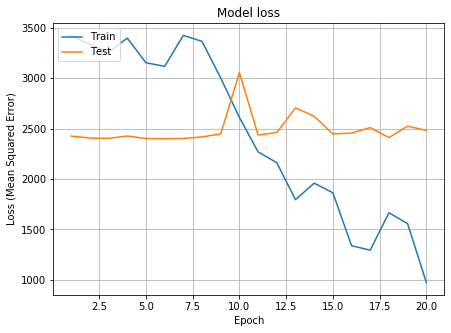


Progress   :  14 / 28
Candidate  :  258
Dropout    :  0.3
Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 37us/step
loss 3199.338952492184
mae 11.123486518859863


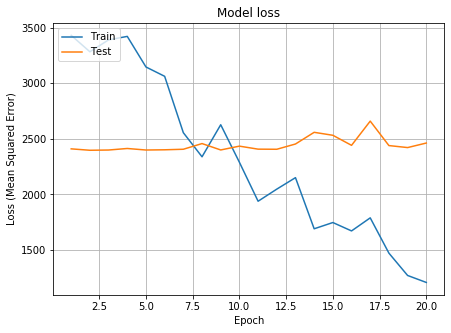


Progress   :  15 / 28
Candidate  :  764
Dropout    :  0
Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 33us/step
loss 967.3794484660712
mae 2.4096672534942627


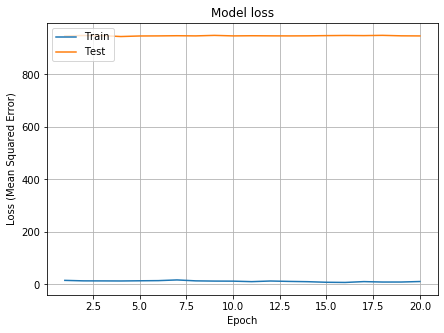


Progress   :  16 / 28
Candidate  :  764
Dropout    :  0.05
Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 38us/step
loss 968.1467432704816
mae 2.3221187591552734


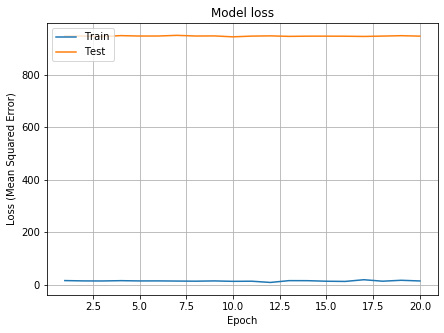


Progress   :  17 / 28
Candidate  :  764
Dropout    :  0.1
Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 37us/step
loss 965.2733305245001
mae 2.9792630672454834


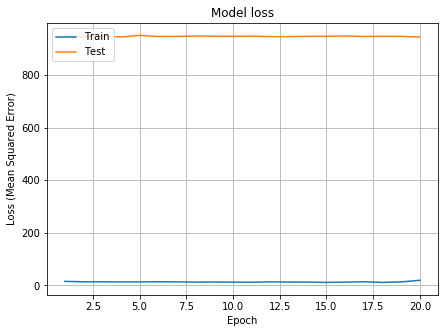


Progress   :  18 / 28
Candidate  :  764
Dropout    :  0.15
Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 32us/step
loss 968.313629758484
mae 2.2811577320098877


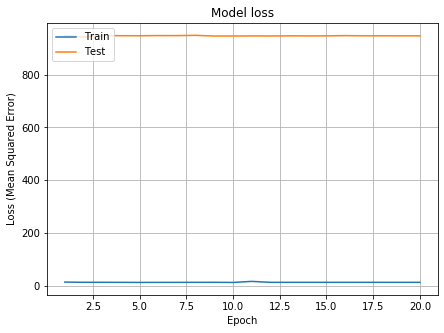


Progress   :  19 / 28
Candidate  :  764
Dropout    :  0.2
Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 34us/step
loss 967.6877045388185
mae 2.3620290756225586


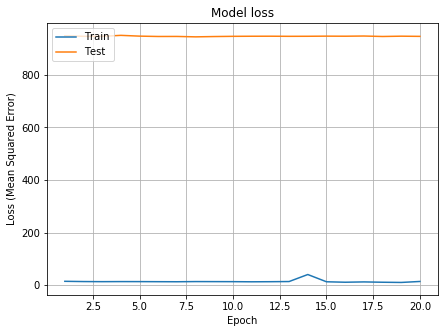


Progress   :  20 / 28
Candidate  :  764
Dropout    :  0.25
Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 34us/step
loss 968.0879518789847
mae 2.334261178970337


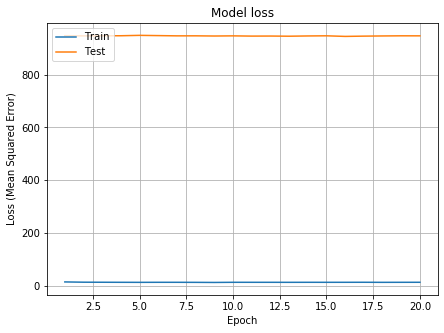


Progress   :  21 / 28
Candidate  :  764
Dropout    :  0.3
Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 37us/step
loss 966.906286036765
mae 2.3876302242279053


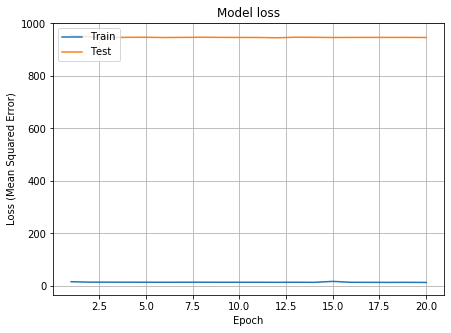


Progress   :  22 / 28
Candidate  :  1467
Dropout    :  0
Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 40us/step
loss 1583.9348065139416
mae 5.246367454528809


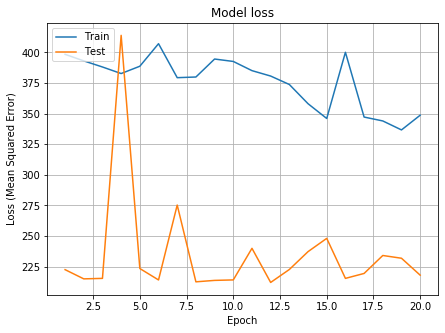


Progress   :  23 / 28
Candidate  :  1467
Dropout    :  0.05
Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 35us/step
loss 1570.1122182999682
mae 6.548269748687744


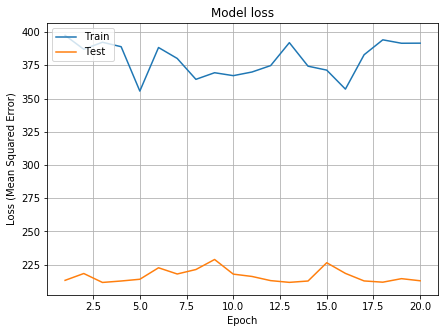


Progress   :  24 / 28
Candidate  :  1467
Dropout    :  0.1
Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 31us/step
loss 1589.4898292435114
mae 4.995185852050781


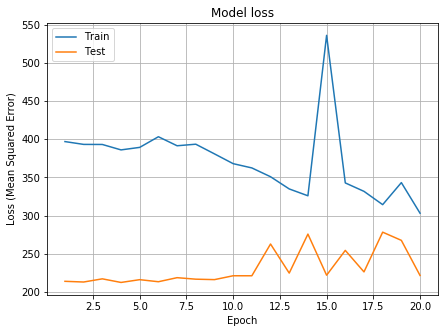


Progress   :  25 / 28
Candidate  :  1467
Dropout    :  0.15
Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 34us/step
loss 1601.9731517517491
mae 5.3368659019470215


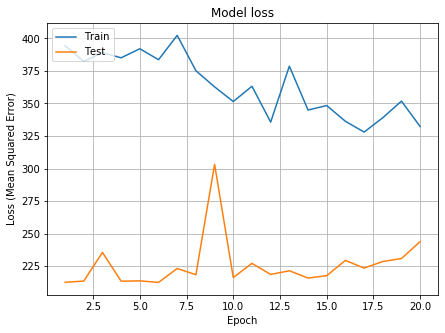


Progress   :  26 / 28
Candidate  :  1467
Dropout    :  0.2
Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 36us/step
loss 1606.6687930493847
mae 5.175418376922607


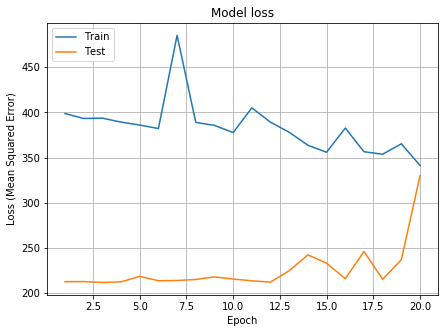


Progress   :  27 / 28
Candidate  :  1467
Dropout    :  0.25
Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 37us/step
loss 1581.12400951867
mae 5.24721622467041


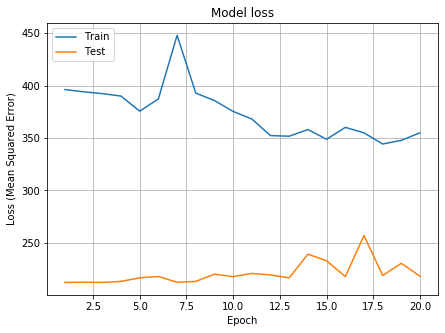


Progress   :  28 / 28
Candidate  :  1467
Dropout    :  0.3
Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 38us/step
loss 1588.990622115989
mae 4.980087757110596


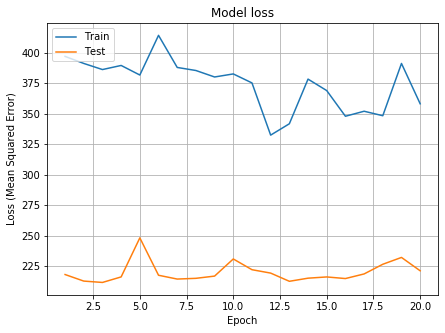

In [17]:
candidate_results3 = {
    159: [],
    258: [],
    764: [],
    1467: [],
}

dropout_val = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
total = len(dropout_val) * len(candidates)
trained = 0

for candidate in candidates:
    for dropout in dropout_val:
        trained += 1
        print("\nProgress   : ", trained, "/", total)
        print("Candidate  : ", candidate)
        print("Dropout    : ", dropout)


        model = Sequential()
        model.add(Dense(units=256, activation='relu', input_shape=(4096,), bias_initializer='ones'))

        for _ in range(6):
            if dropout > 0:
                model.add(Dropout(dropout))
            model.add(Dense(units=256, activation='relu', bias_initializer='ones'))

        model.add(Dense(units=1))
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

        y_train_data = normalize(y_train[:, candidate])
        y_test_data = normalize(y_test[:, candidate])
        history = model.fit(x_train, y_train_data, epochs=20, batch_size=32, validation_split=0.2, verbose=3)
        results = model.evaluate(x_test, y_test_data, batch_size=32, verbose=1)
        labels = model.metrics_names

        # results = [loss, mae]
        for i in range(len(results)):
            print(labels[i], results[i])

        candidate_results3[candidate].append(results[0])

        #Plot training & validation loss values
        fig = plt.figure(figsize=(7,5))
        ax = fig.add_subplot(1,1,1)
        ax.plot(range(1, len(history.history['loss'])+1), history.history['loss'])
        ax.plot(range(1, len(history.history['loss'])+1), history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss (Mean Squared Error)')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.grid()
        plt.show()

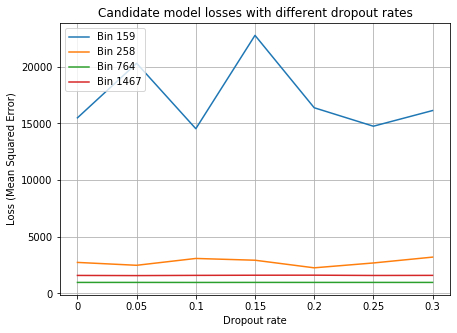

In [19]:
#Plot comparison graph
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)
X = np.arange(0, 8, 2)

legend = []
for c in candidates:
    legend.append('Bin ' + str(c))
    ax.plot(candidate_results3[c])
    
plt.title('Candidate model losses with different dropout rates')
plt.ylabel('Loss (Mean Squared Error)')
plt.xticks(range(len(dropout_val)), dropout_val)
plt.legend(legend, loc='upper left')
plt.xlabel("Dropout rate")
plt.grid()
#plt.ylim(0,4000)
plt.savefig("../dissertation/graphs/candidate-dropout.pdf")
plt.show()

# Multi bin prediction
## Comparing number of layers (256 units, dropout 0.25)


Progress   :  1 / 48
Start index  :  0
Hidden layers:  1
Bin size    :  10
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 52us/step
loss -0.005611551906220283
mse 11.648687362670898


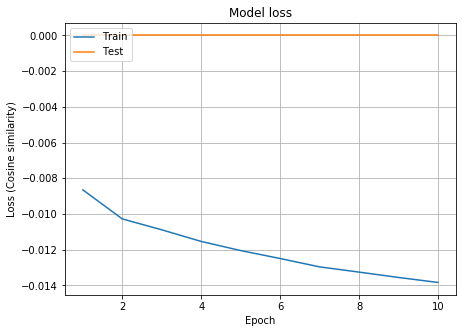


Progress   :  2 / 48
Start index  :  0
Hidden layers:  3
Bin size    :  10
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 32us/step
loss -0.006226361707043837
mse 253.49063110351562


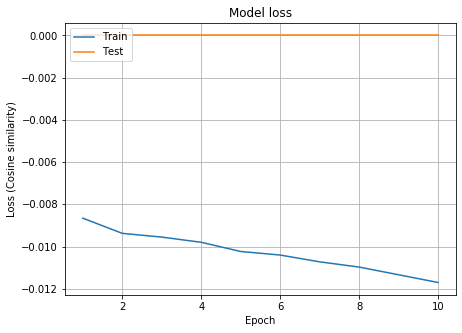


Progress   :  3 / 48
Start index  :  0
Hidden layers:  5
Bin size    :  10
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 38us/step
loss -0.006524142148365256
mse 19928.21484375


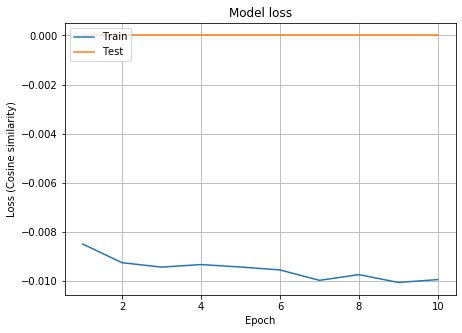


Progress   :  4 / 48
Start index  :  0
Hidden layers:  7
Bin size    :  10
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 37us/step
loss -0.006619023142099526
mse 85774.15625


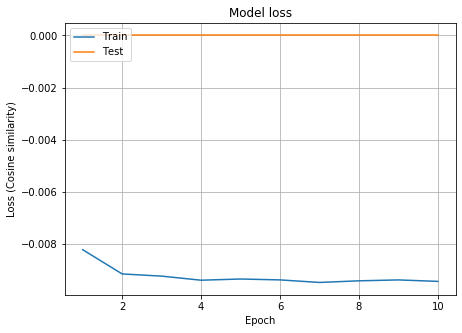


Progress   :  5 / 48
Start index  :  0
Hidden layers:  1
Bin size    :  50
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 29us/step
loss -0.16284023840128103
mse 873.701171875


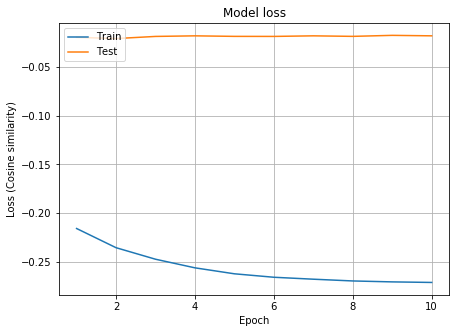


Progress   :  6 / 48
Start index  :  0
Hidden layers:  3
Bin size    :  50
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 32us/step
loss -0.1671598800787585
mse 879.662841796875


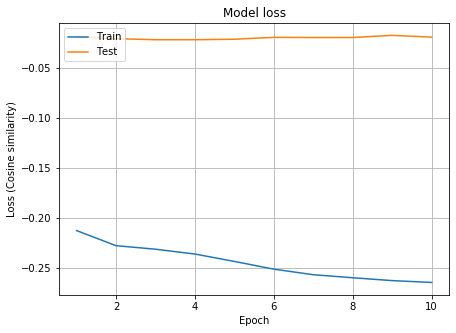


Progress   :  7 / 48
Start index  :  0
Hidden layers:  5
Bin size    :  50
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 35us/step
loss -0.17207754761107888
mse 7772.724609375


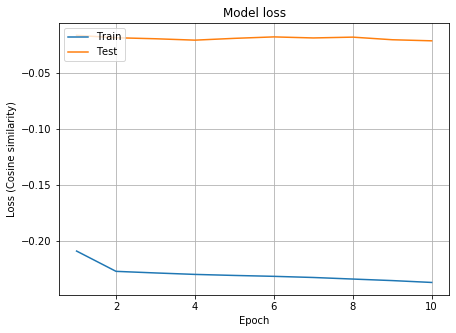


Progress   :  8 / 48
Start index  :  0
Hidden layers:  7
Bin size    :  50
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 34us/step
loss -0.17477439725493116
mse 486538.59375


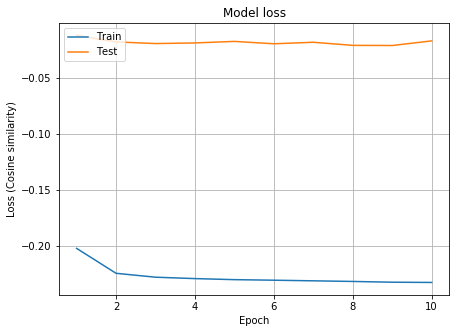


Progress   :  9 / 48
Start index  :  0
Hidden layers:  1
Bin size    :  100
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 26us/step
loss -0.3664780922547719
mse 3124.470703125


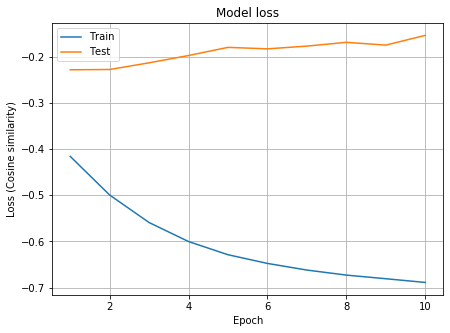


Progress   :  10 / 48
Start index  :  0
Hidden layers:  3
Bin size    :  100
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 33us/step
loss -0.4157822556325471
mse 3084.18017578125


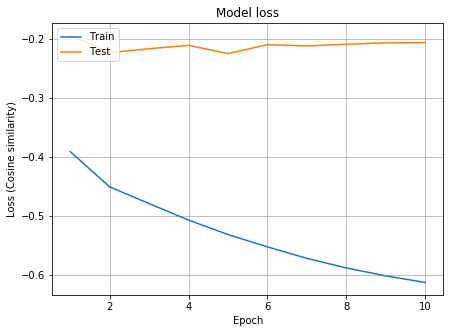


Progress   :  11 / 48
Start index  :  0
Hidden layers:  5
Bin size    :  100
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 39us/step
loss -0.39978838043515824
mse 3252.28564453125


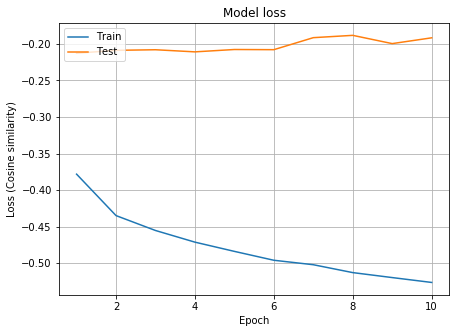


Progress   :  12 / 48
Start index  :  0
Hidden layers:  7
Bin size    :  100
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 40us/step
loss -0.39497061254248667
mse 98397.1328125


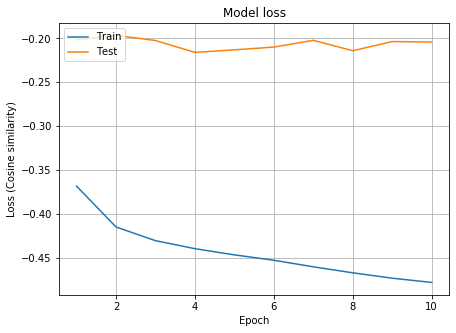


Progress   :  13 / 48
Start index  :  0
Hidden layers:  1
Bin size    :  500
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 28us/step
loss -0.2823845597076081
mse 4016.518798828125


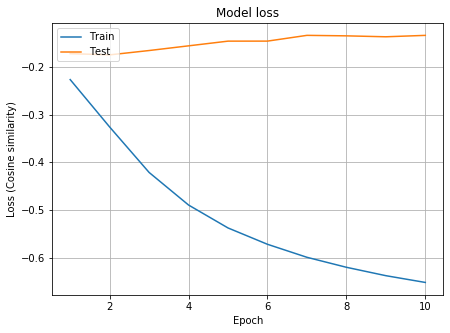


Progress   :  14 / 48
Start index  :  0
Hidden layers:  3
Bin size    :  500
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 34us/step
loss -0.3136086420106626
mse 3989.916748046875


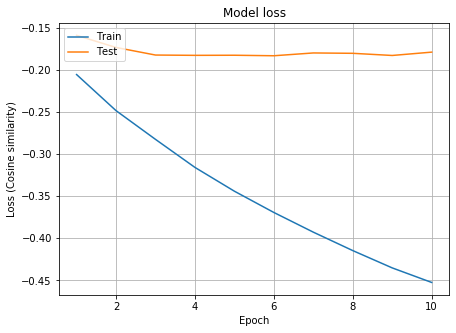


Progress   :  15 / 48
Start index  :  0
Hidden layers:  5
Bin size    :  500
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 36us/step
loss -0.28190711468840024
mse 3812.281982421875


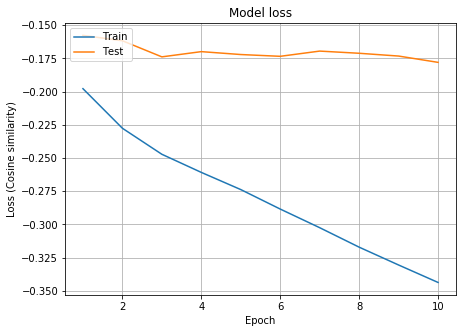


Progress   :  16 / 48
Start index  :  0
Hidden layers:  7
Bin size    :  500
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 41us/step
loss -0.24669357020546562
mse 16110.416015625


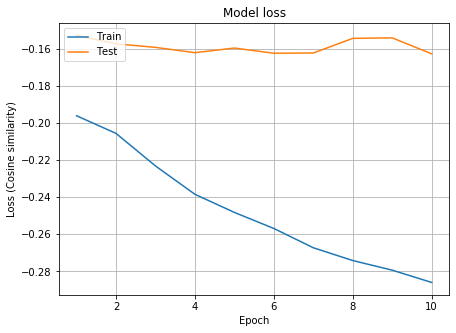


Progress   :  17 / 48
Start index  :  500
Hidden layers:  1
Bin size    :  10
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 29us/step
loss -0.1259587468389624
mse 754.5408325195312


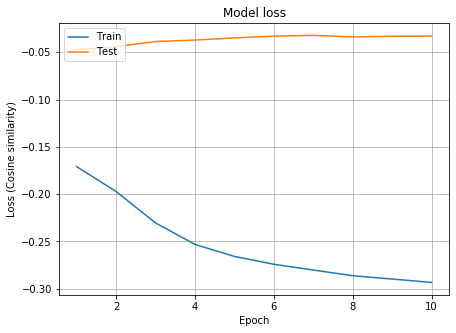


Progress   :  18 / 48
Start index  :  500
Hidden layers:  3
Bin size    :  10
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 33us/step
loss -0.12901480708218988
mse 767.9172973632812


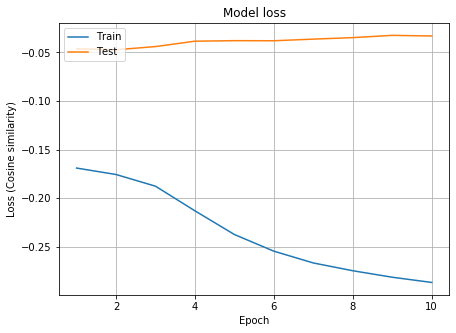


Progress   :  19 / 48
Start index  :  500
Hidden layers:  5
Bin size    :  10
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 37us/step
loss -0.13620476932460904
mse 1804.0030517578125


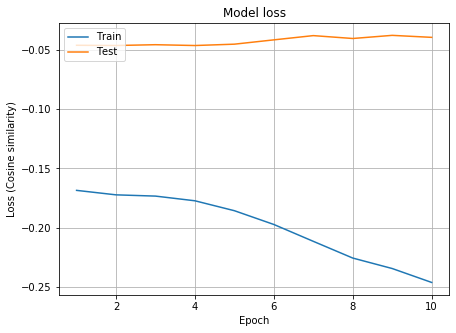


Progress   :  20 / 48
Start index  :  500
Hidden layers:  7
Bin size    :  10
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 37us/step
loss -0.14878056243362042
mse 291748.96875


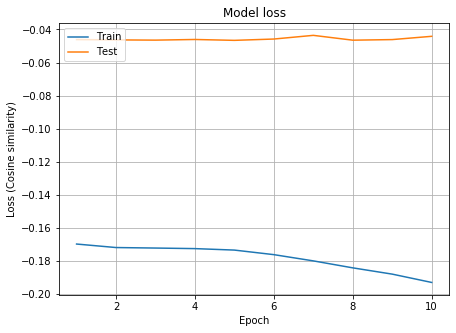


Progress   :  21 / 48
Start index  :  500
Hidden layers:  1
Bin size    :  50
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 29us/step
loss -0.11024639656843391
mse 821.7014770507812


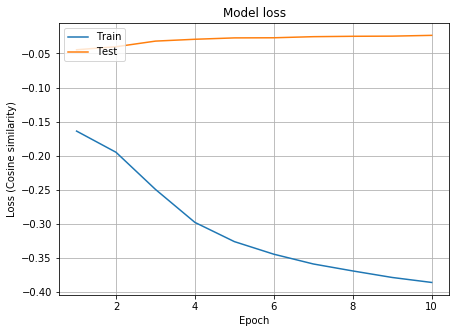


Progress   :  22 / 48
Start index  :  500
Hidden layers:  3
Bin size    :  50
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 35us/step
loss -0.1309339963467911
mse 817.0339965820312


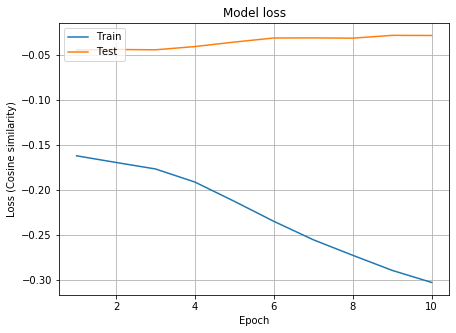


Progress   :  23 / 48
Start index  :  500
Hidden layers:  5
Bin size    :  50
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 34us/step
loss -0.14367520369764342
mse 1107.092529296875


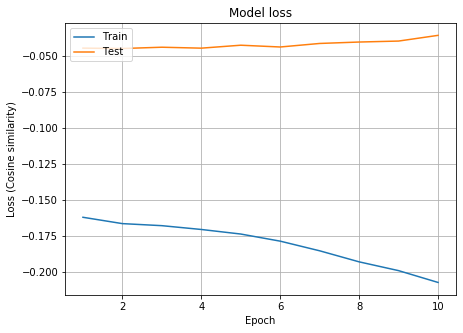


Progress   :  24 / 48
Start index  :  500
Hidden layers:  7
Bin size    :  50
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 34us/step
loss -0.14945978529937679
mse 224354.25


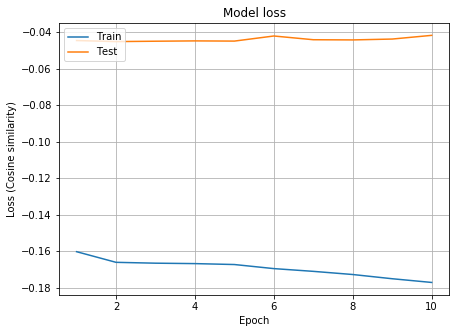


Progress   :  25 / 48
Start index  :  500
Hidden layers:  1
Bin size    :  100
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 27us/step
loss -0.09679020801019275
mse 817.0968627929688


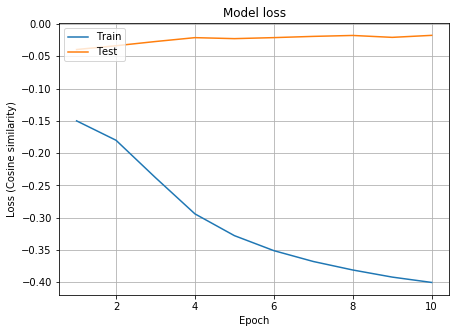


Progress   :  26 / 48
Start index  :  500
Hidden layers:  3
Bin size    :  100
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 30us/step
loss -0.12795557281487668
mse 812.0367431640625


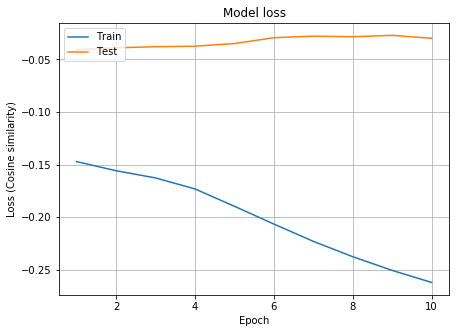


Progress   :  27 / 48
Start index  :  500
Hidden layers:  5
Bin size    :  100
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 32us/step
loss -0.13776799036807008
mse 1118.8248291015625


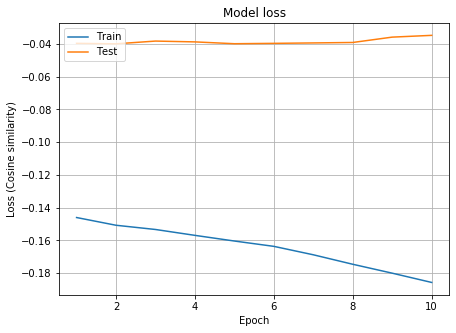


Progress   :  28 / 48
Start index  :  500
Hidden layers:  7
Bin size    :  100
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 34us/step
loss -0.1383580815256133
mse 127842.3515625


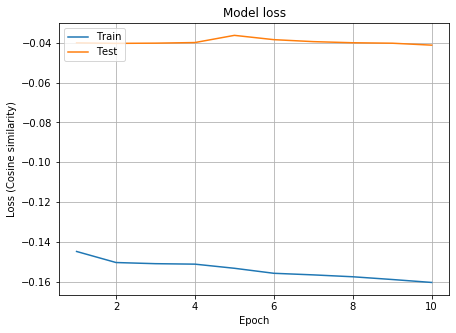


Progress   :  29 / 48
Start index  :  500
Hidden layers:  1
Bin size    :  500
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 28us/step
loss -0.10129388014014863
mse 436.5189514160156


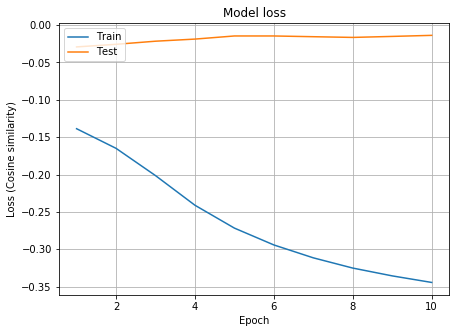


Progress   :  30 / 48
Start index  :  500
Hidden layers:  3
Bin size    :  500
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 31us/step
loss -0.13202115822222046
mse 435.22442626953125


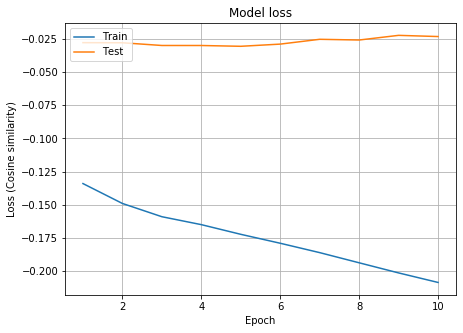


Progress   :  31 / 48
Start index  :  500
Hidden layers:  5
Bin size    :  500
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 33us/step
loss -0.13072176629710372
mse 2377.815673828125


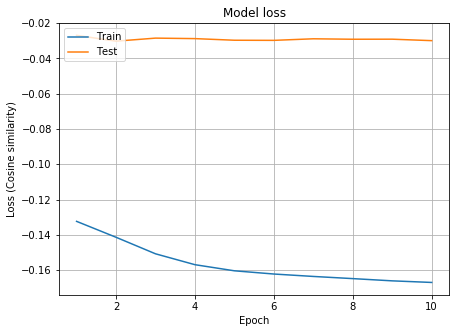


Progress   :  32 / 48
Start index  :  500
Hidden layers:  7
Bin size    :  500
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 35us/step
loss -0.1291328729315001
mse 126958.984375


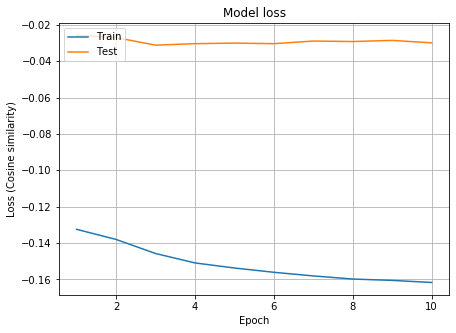


Progress   :  33 / 48
Start index  :  1000
Hidden layers:  1
Bin size    :  10
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 28us/step
loss -0.08273296104204261
mse 208.26934814453125


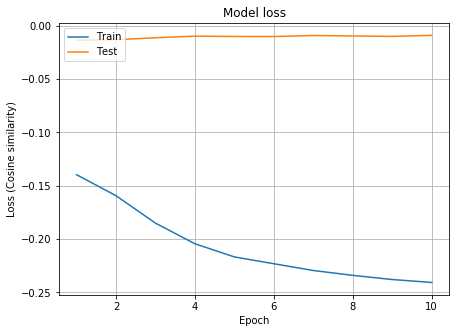


Progress   :  34 / 48
Start index  :  1000
Hidden layers:  3
Bin size    :  10
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 32us/step
loss -0.08781144387060873
mse 234.48182678222656


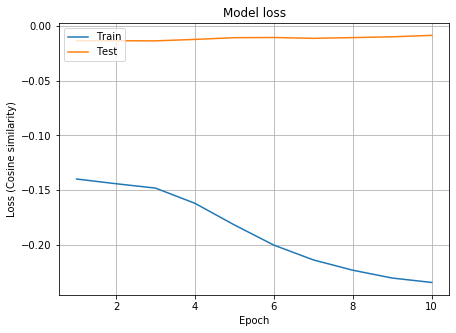


Progress   :  35 / 48
Start index  :  1000
Hidden layers:  5
Bin size    :  10
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 48us/step
loss -0.09657047446442131
mse 1687.791748046875


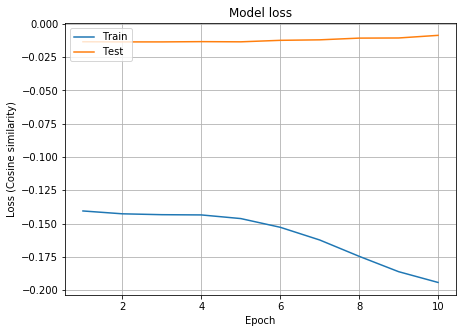


Progress   :  36 / 48
Start index  :  1000
Hidden layers:  7
Bin size    :  10
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 37us/step
loss -0.11644546057553899
mse 262548.46875


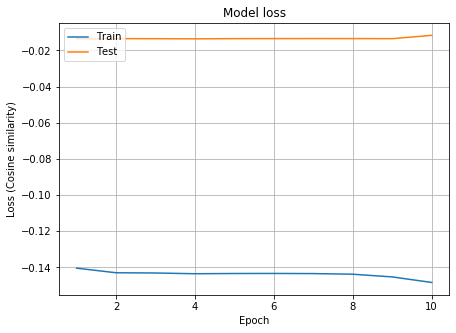


Progress   :  37 / 48
Start index  :  1000
Hidden layers:  1
Bin size    :  50
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 27us/step
loss -0.08266751259188052
mse 157.8016815185547


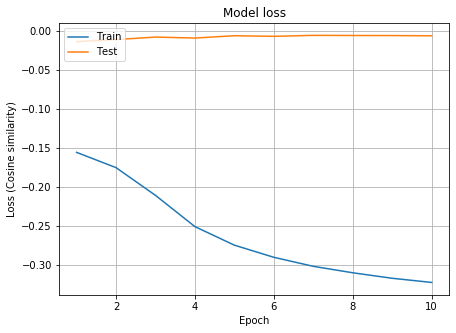


Progress   :  38 / 48
Start index  :  1000
Hidden layers:  3
Bin size    :  50
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 31us/step
loss -0.10598533109166842
mse 157.44677734375


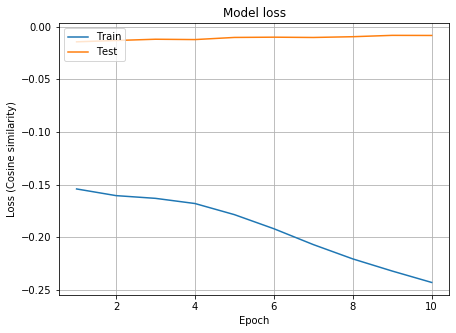


Progress   :  39 / 48
Start index  :  1000
Hidden layers:  5
Bin size    :  50
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 43us/step
loss -0.12066851291280464
mse 456.9288330078125


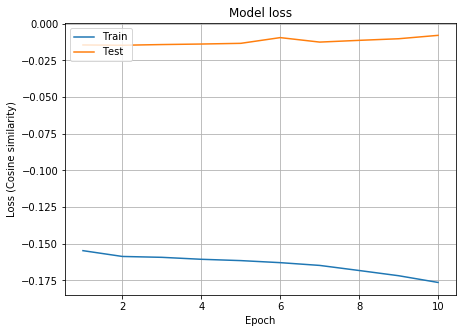


Progress   :  40 / 48
Start index  :  1000
Hidden layers:  7
Bin size    :  50
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 33us/step
loss -0.13411700641912538
mse 237861.109375


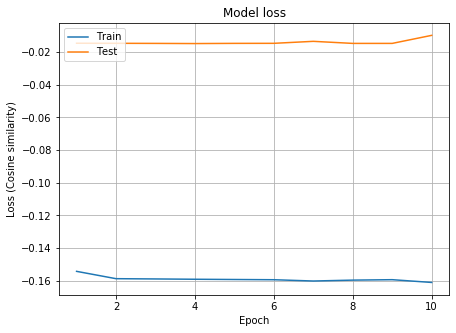


Progress   :  41 / 48
Start index  :  1000
Hidden layers:  1
Bin size    :  100
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 36us/step
loss -0.09682342965471774
mse 146.40028381347656


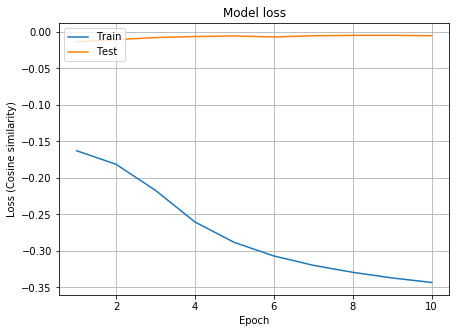


Progress   :  42 / 48
Start index  :  1000
Hidden layers:  3
Bin size    :  100
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 29us/step
loss -0.12024551599790513
mse 146.71807861328125


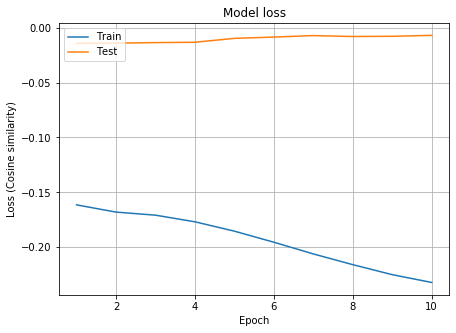


Progress   :  43 / 48
Start index  :  1000
Hidden layers:  5
Bin size    :  100
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 31us/step
loss -0.13820959719453663
mse 553.3369140625


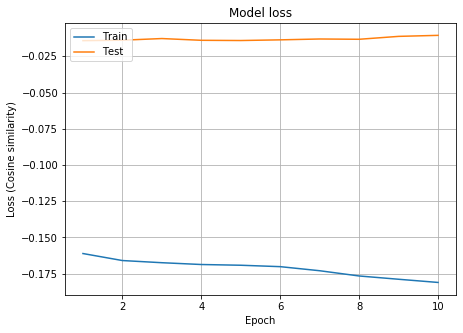


Progress   :  44 / 48
Start index  :  1000
Hidden layers:  7
Bin size    :  100
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 36us/step
loss -0.13856322094207132
mse 687568.8125


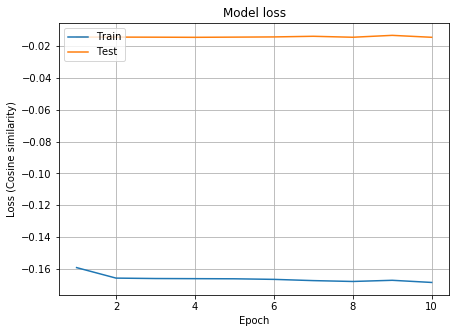


Progress   :  45 / 48
Start index  :  1000
Hidden layers:  1
Bin size    :  500
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 30us/step
loss -0.1384973313598061
mse 119.57274627685547


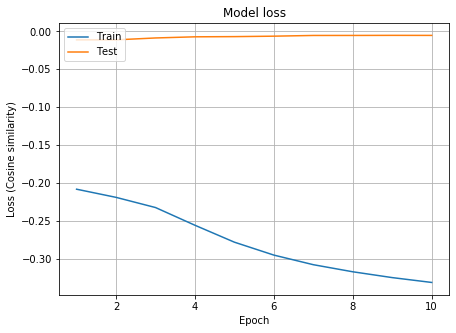


Progress   :  46 / 48
Start index  :  1000
Hidden layers:  3
Bin size    :  500
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 32us/step
loss -0.17457711038846224
mse 122.69905090332031


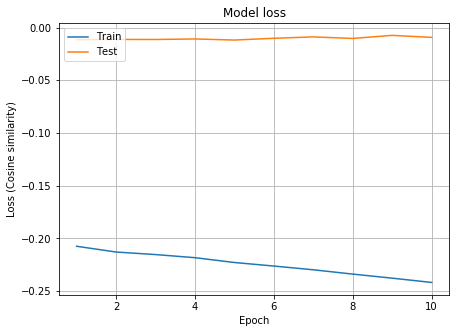


Progress   :  47 / 48
Start index  :  1000
Hidden layers:  5
Bin size    :  500
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 33us/step
loss -0.17868723241411164
mse 5661.20947265625


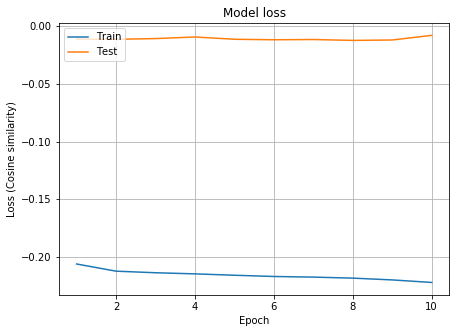


Progress   :  48 / 48
Start index  :  1000
Hidden layers:  7
Bin size    :  500
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 33us/step
loss -0.17518959372162893
mse 497910.40625


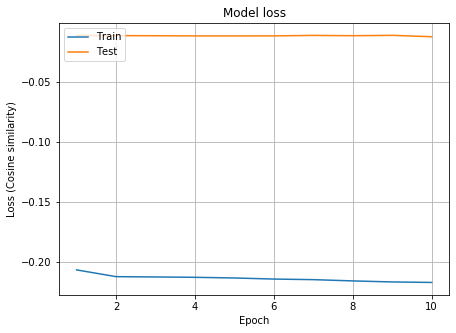

In [48]:
multibin_results = {
    0: {
        10: [],
        50: [],
        100: [],
        500: [],        
    },
    500: {
        10: [],
        50: [],
        100: [],
        500: [],        
    },
    1000: {
        10: [],
        50: [],
        100: [],
        500: [],        
    }
}

starts = [0, 500, 1000]
bin_sizes = [10, 50, 100, 500]
layers = [1, 3, 5, 7]

total = len(starts) * len(bin_sizes) * len(layers)
trained = 0

for start_index in starts:
    for bin_size in bin_sizes:
        for layer in layers:
        
            trained += 1
            print("\nProgress   : ", trained, "/", total)
            print("Start index  : ", start_index)
            print("Hidden layers: ", layer)
            print("Bin size    : ", bin_size)

            end_index = start_index + bin_size

            model = Sequential()
            model.add(Dense(units=256, activation='relu', input_shape=(4096,), bias_initializer='ones'))

            for _ in range(layer - 1):
                model.add(Dropout(0.25))
                model.add(Dense(units=256, activation='relu', bias_initializer='ones'))

            model.add(Dense(units=bin_size))
            model.compile(loss='cosine_proximity', optimizer='adam', metrics=['mse'])


            history = model.fit(x_train, y_train[:, start_index:end_index], epochs=10, batch_size=32, validation_split=0.2, verbose=3)
            results = model.evaluate(x_test, y_test[:, start_index:end_index], batch_size=32, verbose=1)
            labels = model.metrics_names

            # results = [loss, mae]
            for i in range(len(results)):
                print(labels[i], results[i])

            multibin_results[start_index][bin_size].append(results[0])

            #Plot training & validation loss values
            fig = plt.figure(figsize=(7,5))
            ax = fig.add_subplot(1,1,1)
            ax.plot(range(1, len(history.history['loss'])+1), history.history['loss'])
            ax.plot(range(1, len(history.history['loss'])+1), history.history['val_loss'])
            plt.title('Model loss')
            plt.ylabel('Loss (Cosine similarity)')
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Test'], loc='upper left')
            plt.grid()
            plt.show()

In [95]:
multibin_results

{0: {10: [-0.005611551906220283,
   -0.006226361707043837,
   -0.006524142148365256,
   -0.006619023142099526],
  50: [-0.16284023840128103,
   -0.1671598800787585,
   -0.17207754761107888,
   -0.17477439725493116],
  100: [-0.3664780922547719,
   -0.4157822556325471,
   -0.39978838043515824,
   -0.39497061254248667],
  500: [-0.2823845597076081,
   -0.3136086420106626,
   -0.28190711468840024,
   -0.24669357020546562]},
 500: {10: [-0.1259587468389624,
   -0.12901480708218988,
   -0.13620476932460904,
   -0.14878056243362042],
  50: [-0.11024639656843391,
   -0.1309339963467911,
   -0.14367520369764342,
   -0.14945978529937679],
  100: [-0.09679020801019275,
   -0.12795557281487668,
   -0.13776799036807008,
   -0.1383580815256133],
  500: [-0.10129388014014863,
   -0.13202115822222046,
   -0.13072176629710372,
   -0.1291328729315001]},
 1000: {10: [-0.08273296104204261,
   -0.08781144387060873,
   -0.09657047446442131,
   -0.11644546057553899],
  50: [-0.08266751259188052,
   -0.10598

## Comparing number of units (5 layers, dropout 0.25)


Progress   :  1 / 48
Start index  :  0
Hidden layers:  7
Units    :  128
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 35us/step
loss -0.006466901178691647
mse 1228.2266845703125


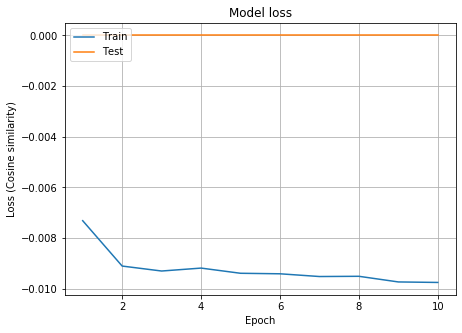


Progress   :  2 / 48
Start index  :  0
Hidden layers:  7
Units    :  512
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 38us/step
loss -0.006572127705888824
mse 1883791.375


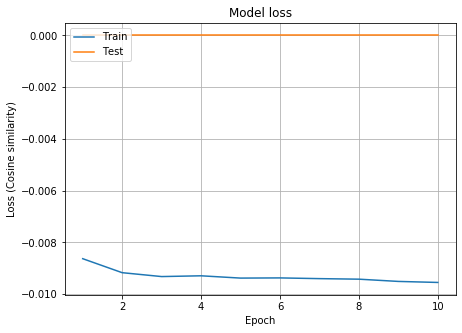


Progress   :  3 / 48
Start index  :  0
Hidden layers:  7
Units    :  1024
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 40us/step
loss -0.0064654825954192875
mse 95763704.0


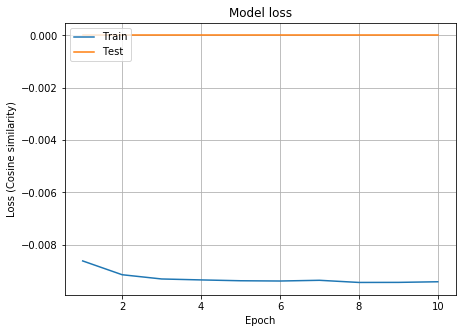


Progress   :  4 / 48
Start index  :  0
Hidden layers:  7
Units    :  2048
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 58us/step
loss -0.0065330525154453575
mse 14179384320.0


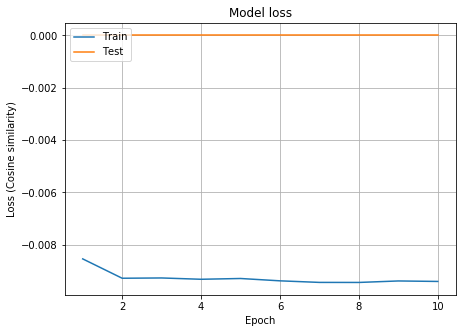


Progress   :  5 / 48
Start index  :  0
Hidden layers:  7
Units    :  128
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 36us/step
loss -0.17478936310184753
mse 3831.0791015625


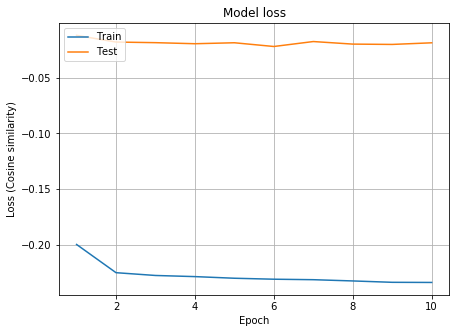


Progress   :  6 / 48
Start index  :  0
Hidden layers:  7
Units    :  512
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 36us/step
loss -0.17461882090358527
mse 4627607.5


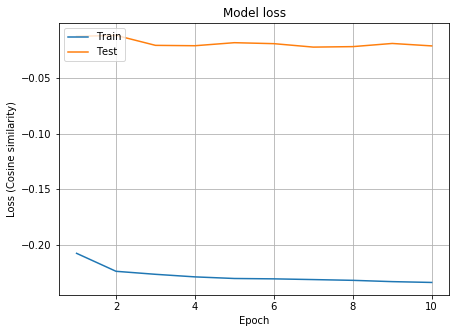


Progress   :  7 / 48
Start index  :  0
Hidden layers:  7
Units    :  1024
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 42us/step
loss -0.1750989990221374
mse 1720246784.0


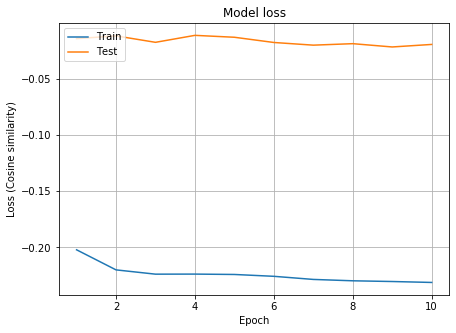


Progress   :  8 / 48
Start index  :  0
Hidden layers:  7
Units    :  2048
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 59us/step
loss -0.17053043386143762
mse 677622644736.0


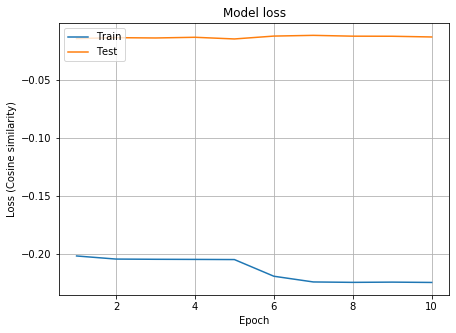


Progress   :  9 / 48
Start index  :  0
Hidden layers:  7
Units    :  128
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 34us/step
loss -0.3964609787086294
mse 3176.881103515625


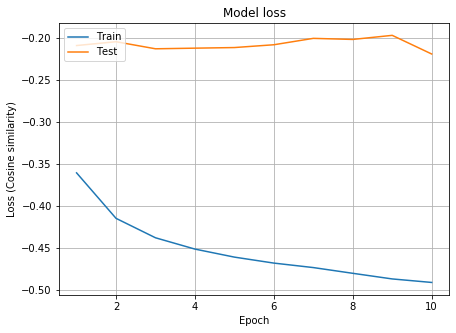


Progress   :  10 / 48
Start index  :  0
Hidden layers:  7
Units    :  512
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 37us/step
loss -0.39080035845028
mse 1242244.125


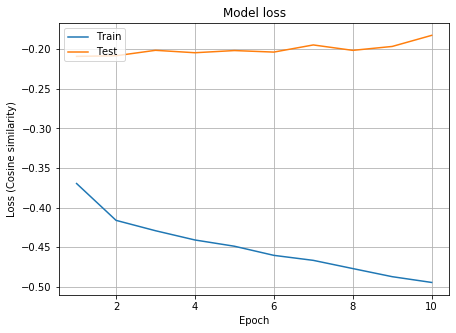


Progress   :  11 / 48
Start index  :  0
Hidden layers:  7
Units    :  1024
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 44us/step
loss -0.39336038873172374
mse 248476944.0


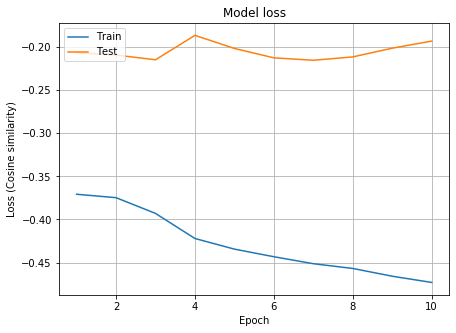


Progress   :  12 / 48
Start index  :  0
Hidden layers:  7
Units    :  2048
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 59us/step
loss -0.34028480866102273
mse 33420158976.0


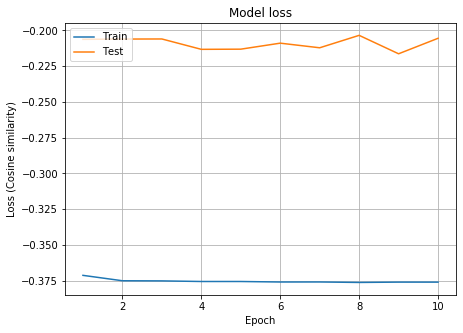


Progress   :  13 / 48
Start index  :  0
Hidden layers:  7
Units    :  128
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 38us/step
loss -0.24587062882206076
mse 3806.46435546875


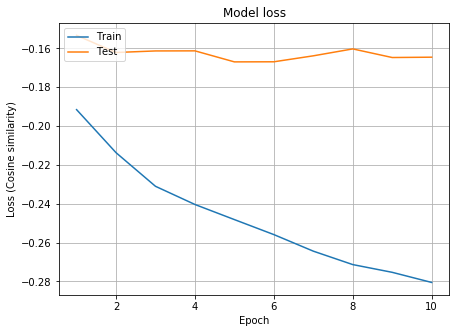


Progress   :  14 / 48
Start index  :  0
Hidden layers:  7
Units    :  512
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 52us/step
loss -0.24673756453378526
mse 201048.5


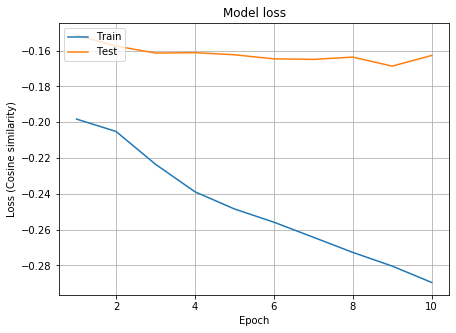


Progress   :  15 / 48
Start index  :  0
Hidden layers:  7
Units    :  1024
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 43us/step
loss -0.23197297334598288
mse 189043104.0


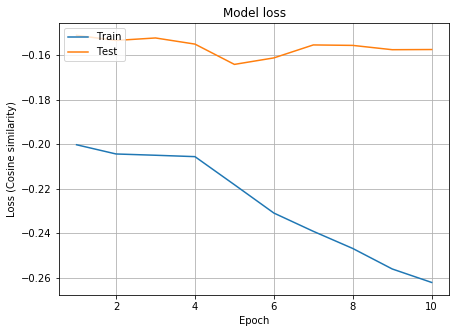


Progress   :  16 / 48
Start index  :  0
Hidden layers:  7
Units    :  2048
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 63us/step
loss -0.19509357175334624
mse 13654146048.0


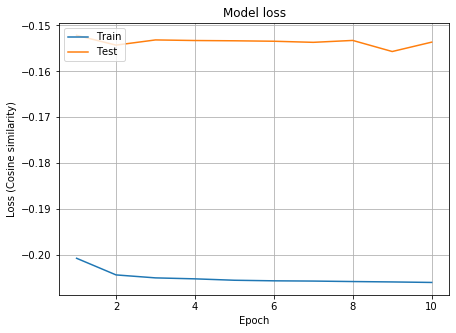


Progress   :  17 / 48
Start index  :  500
Hidden layers:  7
Units    :  128
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 45us/step
loss -0.1476327833640568
mse 1150.8363037109375


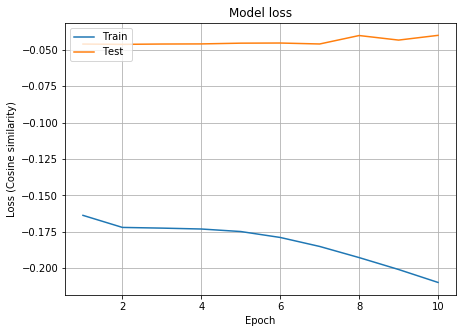


Progress   :  18 / 48
Start index  :  500
Hidden layers:  7
Units    :  512
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 37us/step
loss -0.15305279262586655
mse 3303161.25


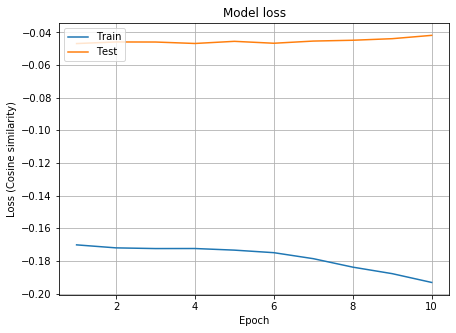


Progress   :  19 / 48
Start index  :  500
Hidden layers:  7
Units    :  1024
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 44us/step
loss -0.15622529374745794
mse 206045584.0


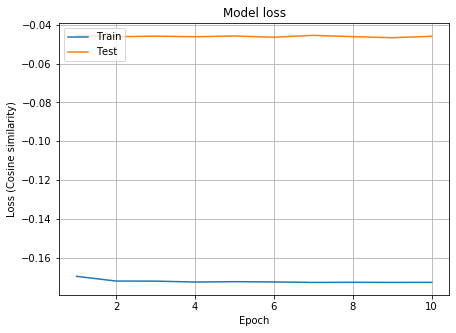


Progress   :  20 / 48
Start index  :  500
Hidden layers:  7
Units    :  2048
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 59us/step
loss -0.15578124341694155
mse 63455559680.0


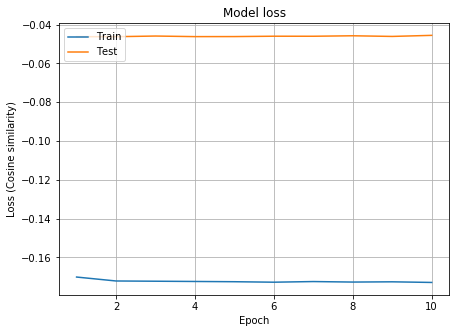


Progress   :  21 / 48
Start index  :  500
Hidden layers:  7
Units    :  128
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 34us/step
loss -0.14711860119796438
mse 1109.5557861328125


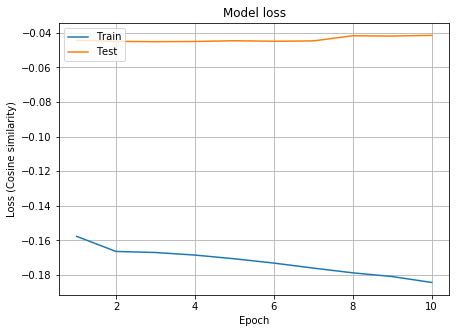


Progress   :  22 / 48
Start index  :  500
Hidden layers:  7
Units    :  512
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 36us/step
loss -0.15136812437300715
mse 4628791.0


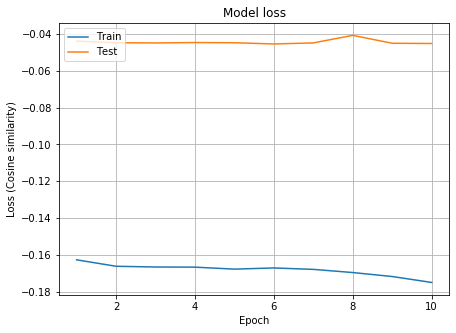


Progress   :  23 / 48
Start index  :  500
Hidden layers:  7
Units    :  1024
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 44us/step
loss -0.1481413406759155
mse 2734423040.0


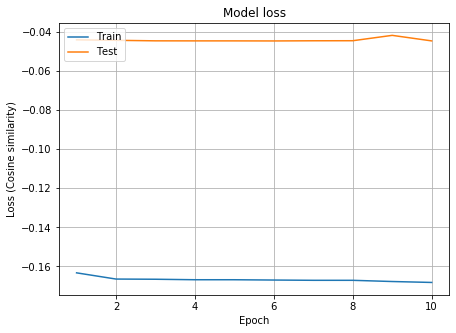


Progress   :  24 / 48
Start index  :  500
Hidden layers:  7
Units    :  2048
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 58us/step
loss -0.1481678344041127
mse 34037536768.0


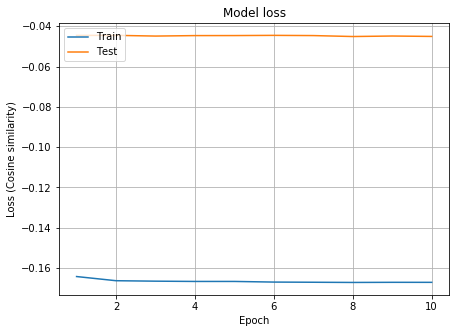


Progress   :  25 / 48
Start index  :  500
Hidden layers:  7
Units    :  128
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 40us/step
loss -0.1402723573732387
mse 1188.9429931640625


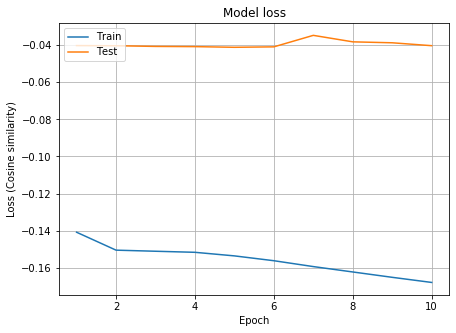


Progress   :  26 / 48
Start index  :  500
Hidden layers:  7
Units    :  512
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 37us/step
loss -0.1376123095932459
mse 1733523.625


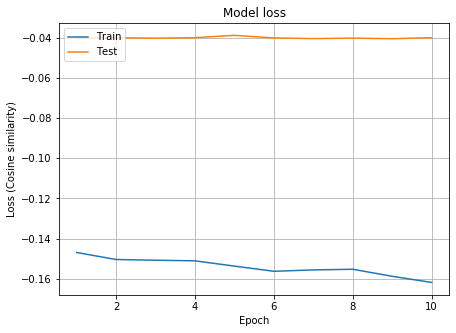


Progress   :  27 / 48
Start index  :  500
Hidden layers:  7
Units    :  1024
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 40us/step
loss -0.13333884659697728
mse 386931808.0


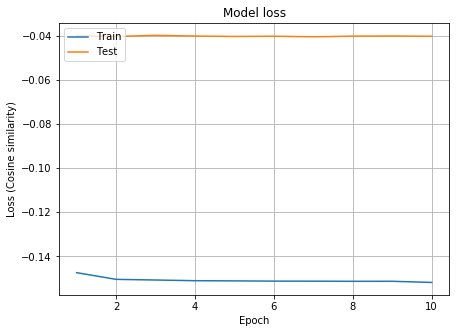


Progress   :  28 / 48
Start index  :  500
Hidden layers:  7
Units    :  2048
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 62us/step
loss -0.13331989504856043
mse 27008124928.0


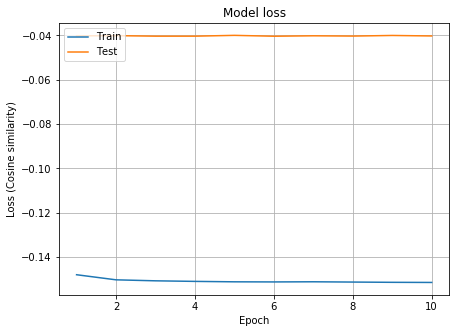


Progress   :  29 / 48
Start index  :  500
Hidden layers:  7
Units    :  128
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 38us/step
loss -0.13207962121780395
mse 1132.302001953125


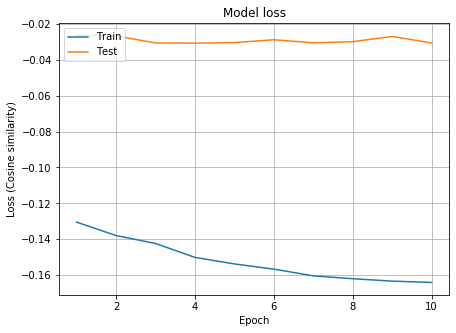


Progress   :  30 / 48
Start index  :  500
Hidden layers:  7
Units    :  512
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 37us/step
loss -0.1291645173792562
mse 1351497.0


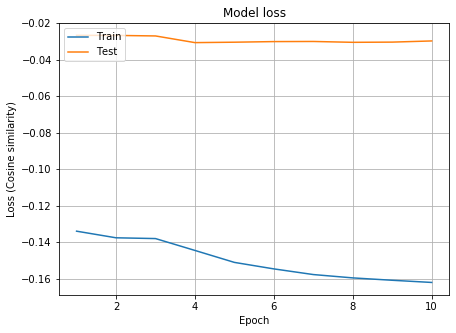


Progress   :  31 / 48
Start index  :  500
Hidden layers:  7
Units    :  1024
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 43us/step
loss -0.12920199622598416
mse 586187200.0


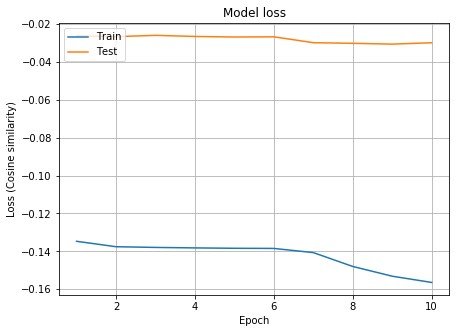


Progress   :  32 / 48
Start index  :  500
Hidden layers:  7
Units    :  2048
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 64us/step
loss -0.11772557634682991
mse 7891594240.0


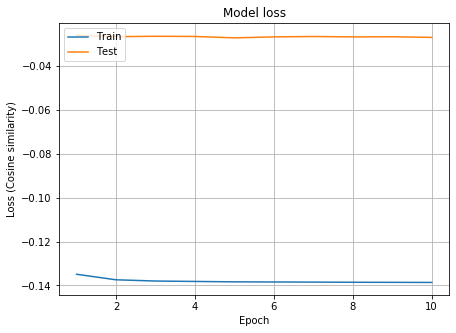


Progress   :  33 / 48
Start index  :  1000
Hidden layers:  7
Units    :  128
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 42us/step
loss -0.10479831807383537
mse 529.8585815429688


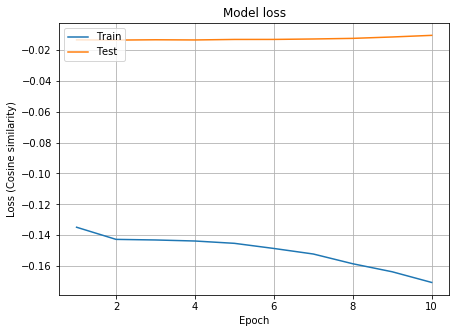


Progress   :  34 / 48
Start index  :  1000
Hidden layers:  7
Units    :  512
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 35us/step
loss -0.1195973692742552
mse 3606699.25


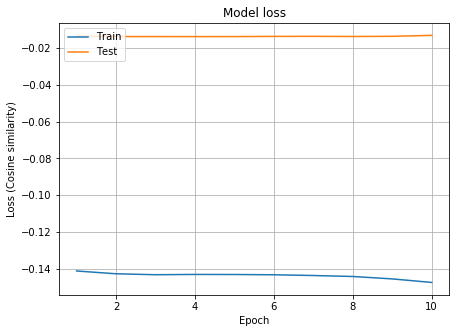


Progress   :  35 / 48
Start index  :  1000
Hidden layers:  7
Units    :  1024
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 40us/step
loss -0.12206430785026108
mse 311349568.0


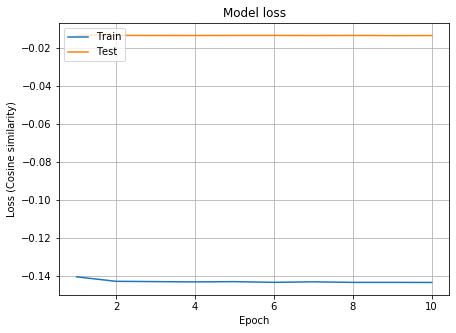


Progress   :  36 / 48
Start index  :  1000
Hidden layers:  7
Units    :  2048
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 62us/step
loss -0.12204792770108776
mse 28177522688.0


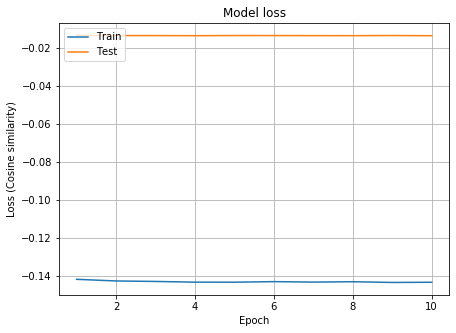


Progress   :  37 / 48
Start index  :  1000
Hidden layers:  7
Units    :  128
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 35us/step
loss -0.13175198815813
mse 499.0506896972656


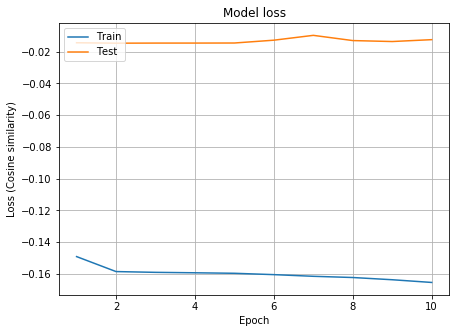


Progress   :  38 / 48
Start index  :  1000
Hidden layers:  7
Units    :  512
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 39us/step
loss -0.13413794207783863
mse 10522612.0


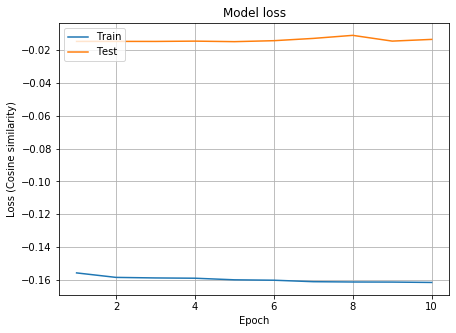


Progress   :  39 / 48
Start index  :  1000
Hidden layers:  7
Units    :  1024
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 44us/step
loss -0.13338469811661205
mse 70514096.0


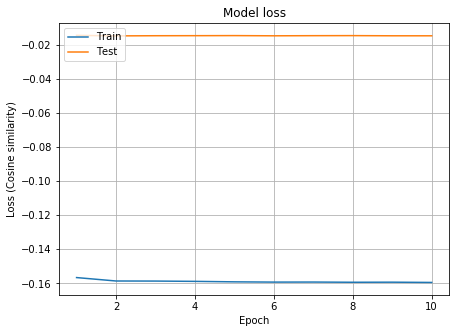


Progress   :  40 / 48
Start index  :  1000
Hidden layers:  7
Units    :  2048
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 60us/step
loss -0.13296149808361155
mse 22153021440.0


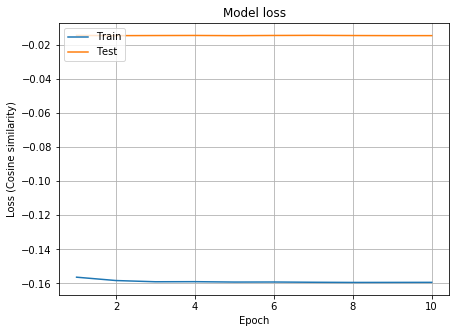


Progress   :  41 / 48
Start index  :  1000
Hidden layers:  7
Units    :  128
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 37us/step
loss -0.13932408030582974
mse 628.4769287109375


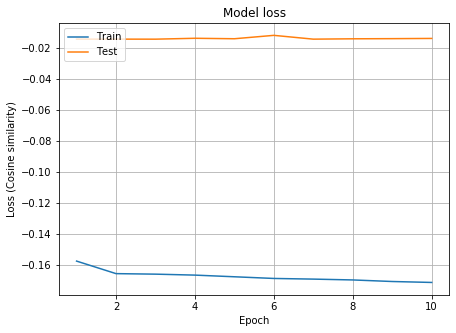


Progress   :  42 / 48
Start index  :  1000
Hidden layers:  7
Units    :  512
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 36us/step
loss -0.13890176576910548
mse 12129737.0


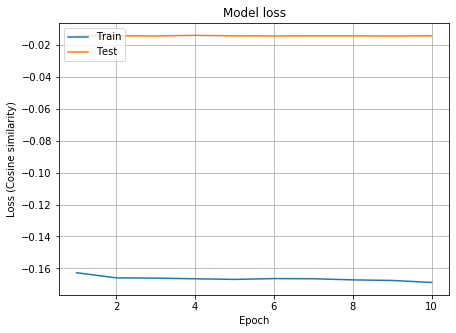


Progress   :  43 / 48
Start index  :  1000
Hidden layers:  7
Units    :  1024
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 40us/step
loss -0.13798110097046667
mse 511900608.0


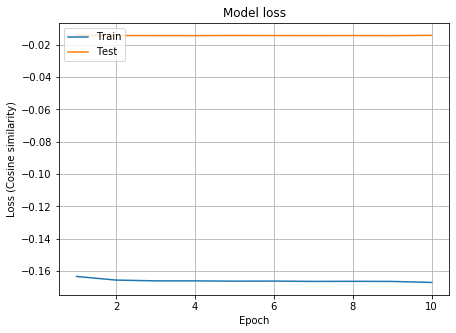


Progress   :  44 / 48
Start index  :  1000
Hidden layers:  7
Units    :  2048
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 58us/step
loss -0.13668183079574658
mse 18545971200.0


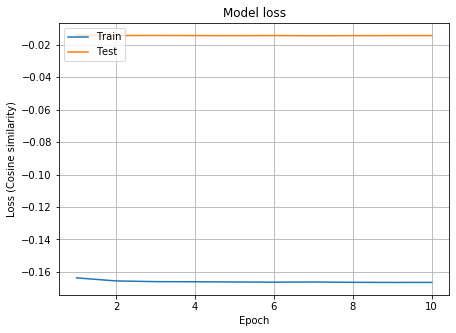


Progress   :  45 / 48
Start index  :  1000
Hidden layers:  7
Units    :  128
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 37us/step
loss -0.17519267348889683
mse 1321.6761474609375


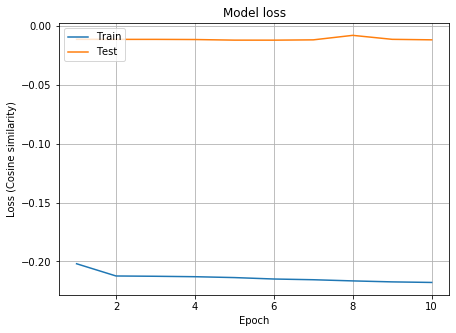


Progress   :  46 / 48
Start index  :  1000
Hidden layers:  7
Units    :  512
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 37us/step
loss -0.17460881623418467
mse 16116412.0


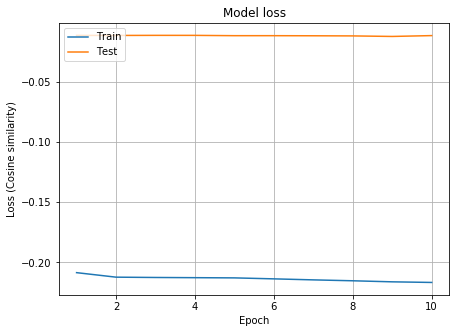


Progress   :  47 / 48
Start index  :  1000
Hidden layers:  7
Units    :  1024
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 43us/step
loss -0.17204642327658065
mse 22743722.0


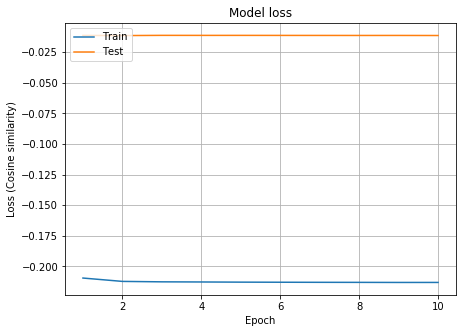


Progress   :  48 / 48
Start index  :  1000
Hidden layers:  7
Units    :  2048
Train on 5280 samples, validate on 1320 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1639/1639 [==============================] - 0s 58us/step
loss -0.1720103861501553
mse 21041483776.0


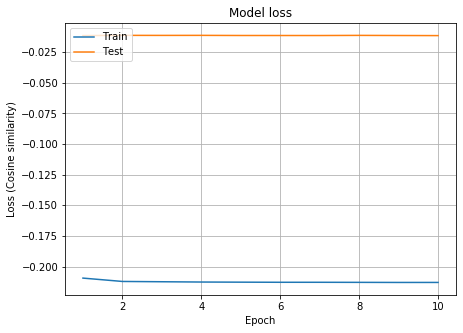

In [76]:
multibin_results2 = {
    0: {
        10: [],
        50: [],
        100: [],
        500: [],        
    },
    500: {
        10: [],
        50: [],
        100: [],
        500: [],        
    },
    1000: {
        10: [],
        50: [],
        100: [],
        500: [],        
    }
}

starts = [0, 500, 1000]
bin_sizes = [10, 50, 100, 500]
n_units = [128, 512, 1024, 2048]

total = len(starts) * len(bin_sizes) * len(layers)
trained = 0

for start_index in starts:
    for bin_size in bin_sizes:
        for units in n_units:
        
            trained += 1
            print("\nProgress   : ", trained, "/", total)
            print("Start index  : ", start_index)
            print("Hidden layers: ", layer)
            print("Units    : ", units)

            end_index = start_index + bin_size

            model = Sequential()
            model.add(Dense(units=units, activation='relu', input_shape=(4096,), bias_initializer='ones'))

            for _ in range(5):
                model.add(Dropout(0.25))
                model.add(Dense(units=units, activation='relu', bias_initializer='ones'))

            model.add(Dense(units=bin_size))
            model.compile(loss='cosine_proximity', optimizer='adam', metrics=['mse'])


            history = model.fit(x_train, y_train[:, start_index:end_index], epochs=10, batch_size=32, validation_split=0.2, verbose=3)
            results = model.evaluate(x_test, y_test[:, start_index:end_index], batch_size=32, verbose=1)
            labels = model.metrics_names

            # results = [loss, mae]
            for i in range(len(results)):
                print(labels[i], results[i])

            multibin_results2[start_index][bin_size].append(results[0])

            #Plot training & validation loss values
            fig = plt.figure(figsize=(7,5))
            ax = fig.add_subplot(1,1,1)
            ax.plot(range(1, len(history.history['loss'])+1), history.history['loss'])
            ax.plot(range(1, len(history.history['loss'])+1), history.history['val_loss'])
            plt.title('Model loss')
            plt.ylabel('Loss (Cosine similarity)')
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Test'], loc='upper left')
            plt.grid()
            plt.show()

In [94]:
multibin_results2

{0: {10: [-0.006466901178691647,
   -0.006572127705888824,
   -0.0064654825954192875,
   -0.0065330525154453575],
  50: [-0.17478936310184753,
   -0.17461882090358527,
   -0.1750989990221374,
   -0.17053043386143762],
  100: [-0.3964609787086294,
   -0.39080035845028,
   -0.39336038873172374,
   -0.34028480866102273],
  500: [-0.24587062882206076,
   -0.24673756453378526,
   -0.23197297334598288,
   -0.19509357175334624]},
 500: {10: [-0.1476327833640568,
   -0.15305279262586655,
   -0.15622529374745794,
   -0.15578124341694155],
  50: [-0.14711860119796438,
   -0.15136812437300715,
   -0.1481413406759155,
   -0.1481678344041127],
  100: [-0.1402723573732387,
   -0.1376123095932459,
   -0.13333884659697728,
   -0.13331989504856043],
  500: [-0.13207962121780395,
   -0.1291645173792562,
   -0.12920199622598416,
   -0.11772557634682991]},
 1000: {10: [-0.10479831807383537,
   -0.1195973692742552,
   -0.12206430785026108,
   -0.12204792770108776],
  50: [-0.13175198815813,
   -0.134137942

## Whole spectrum (5 layers, 128 units)

Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 46us/step
loss -0.28386636611126487
mse 1147.6309814453125


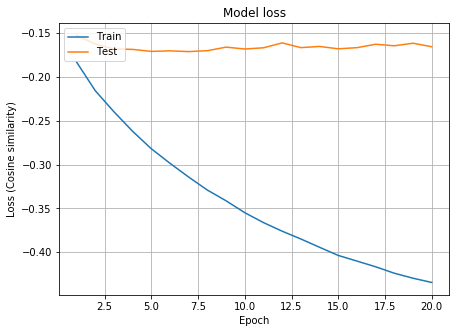

Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 54us/step
loss -0.2955524680534829
mse 1140.0679931640625


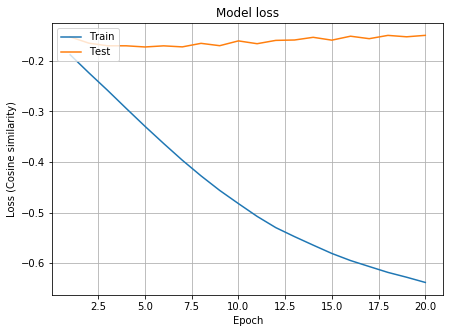

Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 46us/step
loss -0.3017853633105719
mse 1125.07861328125


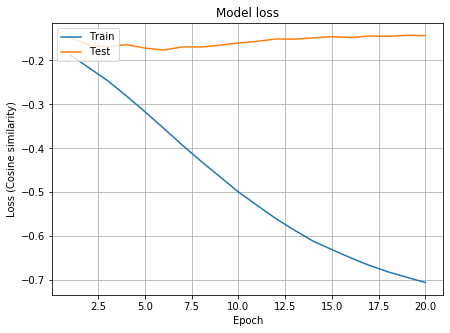

Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 55us/step
loss -0.2930502566515199
mse 1090.131103515625


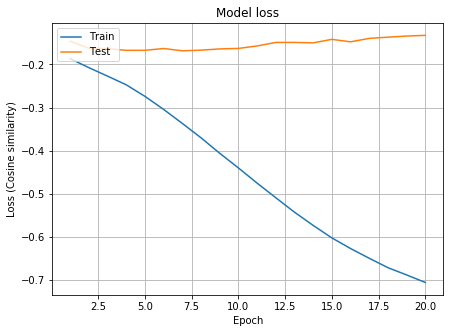

Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 41us/step
loss -0.2720259738457574
mse 1141.131591796875


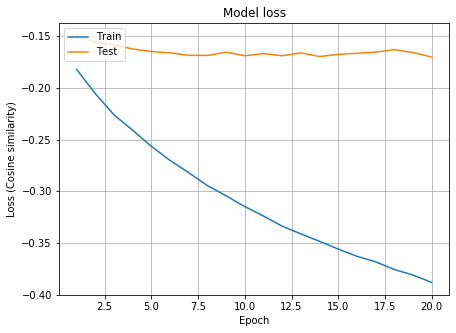

Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 40us/step
loss -0.2859433213927311
mse 1108.5457763671875


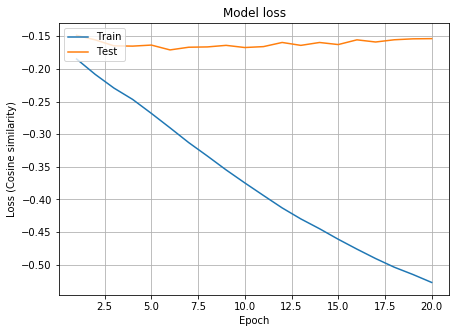

Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 47us/step
loss -0.28528106471727066
mse 1148.0594482421875


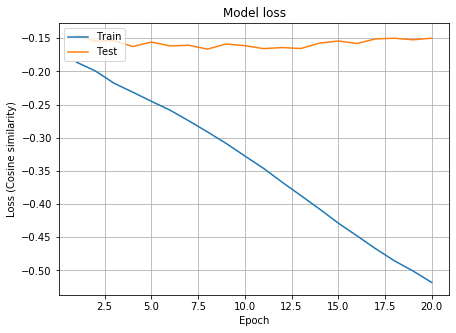

Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 58us/step
loss -0.2704521251013906
mse 29888.3203125


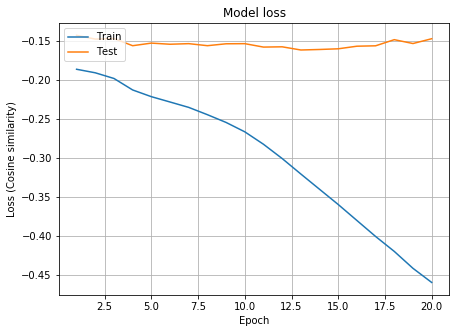

Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 41us/step
loss -0.2570451380795208
mse 1126.704833984375


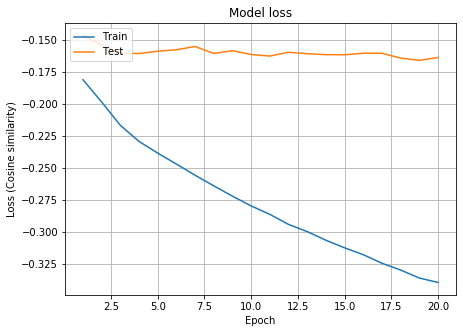

Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 41us/step
loss -0.2663210968761418
mse 1358.108642578125


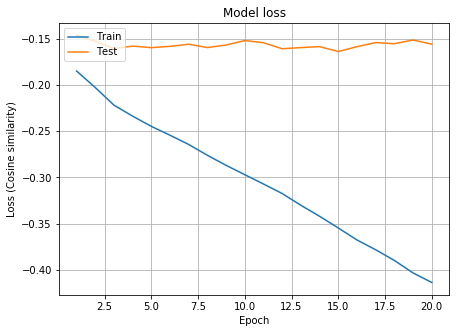

Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 60us/step
loss -0.2512416623128195
mse 177819.15625


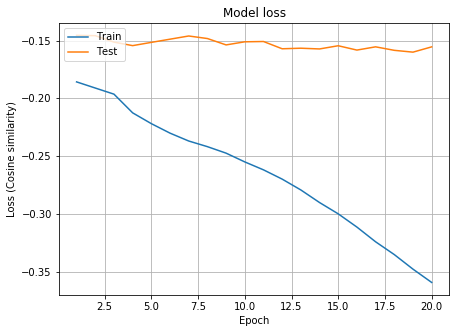

Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 62us/step
loss -0.2218111887474188
mse 215136528.0


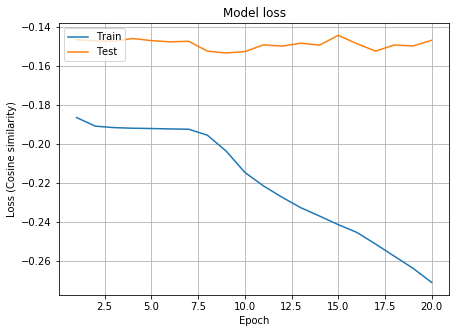

Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 42us/step
loss -0.23412174601937447
mse 1098.246826171875


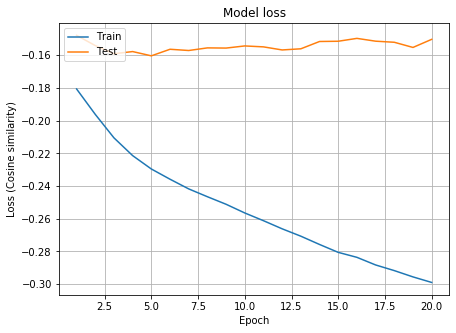

Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 48us/step
loss -0.23931610115131566
mse 118472.328125


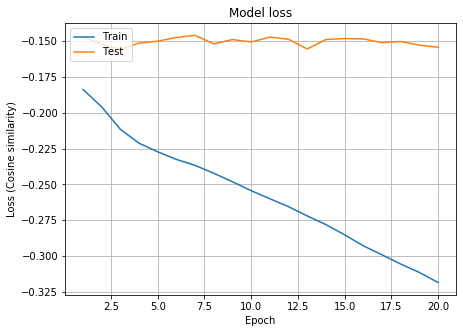

Train on 5280 samples, validate on 1320 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 50us/step
loss -0.22945184064682408
mse 84798120.0


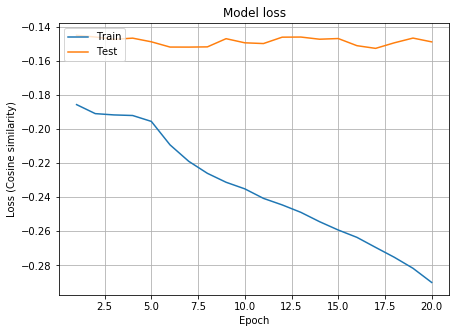

Train on 5280 samples, validate on 1320 samples
Epoch 1/20


ResourceExhaustedError:  OOM when allocating tensor with shape[4096,2048] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node mul_13088 (defined at /home/cameron/anaconda3/envs/dissertation/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3009) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_keras_scratch_graph_3917217]

Function call stack:
keras_scratch_graph


In [109]:
model_results = {}


units = [128, 256, 512, 1024]
n_layers = [2, 3, 4, 5]

for layers in n_layers:
    for units in n_units:

        model = Sequential()
        model.add(Dense(units=units, activation='relu', input_shape=(4096,), bias_initializer='ones'))

        for _ in range(layers):
            model.add(Dropout(0.25))
            model.add(Dense(units=units, activation='relu', bias_initializer='ones'))

        model.add(Dense(units=np.shape(y_train)[1]))
        model.compile(loss='cosine_proximity', optimizer='adam', metrics=['mse'])


        history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=3)
        results = model.evaluate(x_test, y_test, batch_size=32, verbose=1)
        labels = model.metrics_names

        # results = [loss, mae]
        for i in range(len(results)):
            print(labels[i], results[i])
        
        model_results[(layers, units)] = results[0]

        #Plot training & validation loss values
        fig = plt.figure(figsize=(7,5))
        ax = fig.add_subplot(1,1,1)
        ax.plot(range(1, len(history.history['loss'])+1), history.history['loss'])
        ax.plot(range(1, len(history.history['loss'])+1), history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss (Cosine similarity)')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.grid()
        plt.show()

In [110]:
model_results

{(2, 128): -0.28386636611126487,
 (2, 512): -0.2955524680534829,
 (2, 1024): -0.3017853633105719,
 (2, 2048): -0.2930502566515199,
 (3, 128): -0.2720259738457574,
 (3, 512): -0.2859433213927311,
 (3, 1024): -0.28528106471727066,
 (3, 2048): -0.2704521251013906,
 (4, 128): -0.2570451380795208,
 (4, 512): -0.2663210968761418,
 (4, 1024): -0.2512416623128195,
 (4, 2048): -0.2218111887474188,
 (5, 128): -0.23412174601937447,
 (5, 512): -0.23931610115131566,
 (5, 1024): -0.22945184064682408}

In [112]:

{k: v for k, v in sorted(model_results.items(), key=lambda item: item[1])}


{(2, 1024): -0.3017853633105719,
 (2, 512): -0.2955524680534829,
 (2, 2048): -0.2930502566515199,
 (3, 512): -0.2859433213927311,
 (3, 1024): -0.28528106471727066,
 (2, 128): -0.28386636611126487,
 (3, 128): -0.2720259738457574,
 (3, 2048): -0.2704521251013906,
 (4, 512): -0.2663210968761418,
 (4, 128): -0.2570451380795208,
 (4, 1024): -0.2512416623128195,
 (5, 512): -0.23931610115131566,
 (5, 128): -0.23412174601937447,
 (5, 1024): -0.22945184064682408,
 (4, 2048): -0.2218111887474188}

## Calculating Recall @ X

In [18]:
#### train model with best parameters
final_model = Sequential()
final_model.add(Dense(units=1024, activation='relu', input_shape=(4096,), bias_initializer='ones'))
for _ in range(2):
    final_model.add(Dropout(0.25))
    final_model.add(Dense(units=1024, activation='relu', bias_initializer='ones'))
final_model.add(Dense(units=np.shape(y_train)[1]))
final_model.compile(loss='cosine_proximity', optimizer='adam', metrics=['mse'])
final_model.fit(x_train, y_train, epochs=20, batch_size=32, verbose=3)

results = final_model.evaluate(x_test, y_test, batch_size=32, verbose=1)
labels = final_model.metrics_names
# results = [loss, mae]
for i in range(len(results)):
    print(labels[i], results[i])

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1639/1639 [==============================] - 0s 69us/step
loss -0.30830556464275255
mse 1122.197998046875


In [11]:
predictions = final_model.predict(x_test)

fp_similarity_matches = []

for i, mol in enumerate(x_test):
    mol_index = get_best_fp_match(test_mols['fingerprint'][i], train_mols, 1)[0][1]
    fp_similarity_matches.append(y_train[mol_index])

ranks = [1, 5, 10, 20, 30, 40, 50]
model_recalls = []
fp_match_recalls = []

for rank in ranks:
    print("Calculating recall @ ", rank)
    model_recalls.append(get_rank_at_n_score(predictions, y_test, rank))
    fp_match_recalls.append(get_rank_at_n_score(fp_similarity_matches, y_test, rank))

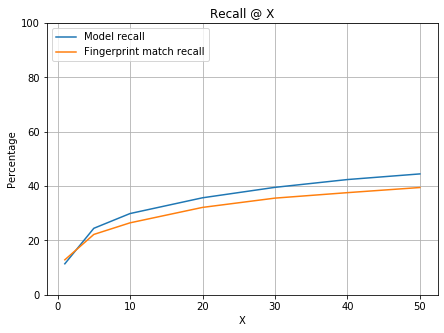

In [21]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)
ax.plot(ranks, model_recalls)
ax.plot(ranks, fp_match_recalls)
plt.title('Recall @ X')
plt.ylabel('Percentage')
plt.ylim(0, 100)
plt.xlabel('X')
plt.legend(['Model recall', 'Fingerprint match recall'], loc='upper left')
plt.savefig("../dissertation/graphs/recall.pdf")
plt.grid()
plt.show()